# Calibración nubosidad ISCCP-H 

---
---

## Objetivos

El objetivo de este trabajo es validar la nubosidad estimada por satélite en ISCCP-H

## Datos

Los datos a utilziar son datos de ISCCP-H diarios y mensuales

## Metodología


## Código

### Interacción con otros códigos:

#### Funciones

#### Clases

## Resultados

## Conclusiones

---
---

#pendientes:

Armar grafico con frecuencias mensuales de datos diarios (calculadas)

**Cargo módulos necesarios:**

In [1]:
import warnings
warnings.filterwarnings("ignore") #para que muestre los warnings una sola vez


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import xarray as xr
import datetime as dt

**Cargo módulos con funciones propias necesarias:**

In [2]:
from f_abrir_datos_smn import abrir_datos_smn
from f_make_grid import make_grid
from f_mis_shapes import df_paises, df_provincias
from f_graficos_calibracion import grafico_puntos, grafico_puntos_paper, histograma_oktas_sat, histograma_oktas_sat_smn
from f_cargo_datos_isccp import cargo_datos_ISCCP
from f_porc_to_oktas import data_frame_oktas
from f_puntos_cercanos import puntos_cercanos
from f_tablas_de_contingencia_nubosidad import generar_tabla_contingencia

from f_graficos_calibracion import scatter, histograma, stackplot, barplot_oktas_separadas, histogramas_partidos, histograma_oktas_sat_smn, histogramas_partidos_poster
from f_procesamiento_satelite import frecuencia_oktas_por_anio, frecuencia_oktas_por_anio_estaciones, frecuencia_oktas_por_anio_meses, frecuencia_oktas_por_mes, agrupo_frecuencias, agrupo_data
import f_procesamiento_smn
from c_clases_satelite import dataframe_satelite, frecuencias_oktas
from c_clases_smn import dataframe_smn
import f_paletas_colores

**Estas son las lineas que tiene que cambiar le usuarie:**

**RUTAS**

In [3]:
cwd = os.getcwd()
print("Current working directory: {0}".format(cwd))

trabajo_en_mi_pc = False
trabajo_en_vegeta = True

if trabajo_en_mi_pc:
    None
    #OJO los datos no estan cargados en mi PC
    #si estoy trabajando desde mi pc parada en directorio ./Doctorado/codigos/codigos2021/nubosidad
    #ruta_a_archivos = "../../../datos/smn/smn_variables_1961-2021/" #ruta donde estan los archivos con datos del smn
    #ruta_a_resultados = "../../../resultados/resultados2021/nubosidad/" #ruta donde se guardan los resultados del analisis de nubosidad
     
if trabajo_en_vegeta:
    #si estoy trabajando desde el servidor vegeta
    ruta_a_archivos_isccp_diario = "/pikachu/datos2/isccp-h/HGG" #ruta donde estan los archivos con datos de isccp-h
    ruta_a_archivos_isccp_mensual = "/pikachu/datos2/isccp-h/HGM" #ruta donde estan los archivos con datos de isccp-h
   
    ruta_a_archivos_smn = "/pikachu/datos/nadia.testani/Doctorado/datos/smn/smn_variables_1961-2021/" #ruta donde estan los archivos con datos del smn
    ruta_a_archivos_smn_mensual = "/pikachu/datos/nadia.testani/Doctorado/resultados/resultados2021/nubosidad/nubosidad_observada/smn/data_mensual/admite_20porc_na/datos"
    ruta_a_archivo_estaciones_smn = "/pikachu/datos/nadia.testani/Doctorado/datos/smn/" 
    ruta_a_resultados = "/pikachu/datos/nadia.testani/Doctorado/resultados/resultados2021/nubosidad/" #ruta donde se guardan los resultados del analisis de nubosidad
#os.chdir("../../../../../../../../../../")    

Current working directory: /home/nadia.testani/Doctorado/codigos/codigos2021/nubosidad


**FECHAS**

In [4]:
fecha_inicio_str = "1983-12"
fecha_final_str = "2016-11"
fecha_inicio_str_1 = "1983-12"
fecha_final_str_1 = "1999-12"
fecha_inicio_str_2 = "1999-12"
fecha_final_str_2 = "2015-12"
fecha_inicio_str_0 = "1967-12"
fecha_final_str_0 = "1983-12"

#fecha_inicio_str = "1961-01-01"
#fecha_final_str = "2020-12-31"
#fecha_inicio_str_1 = "1961-01-01" 
#fecha_final_str_1 = "1989-12-31"
#fecha_inicio_str_2 = "1990-01-01"
#fecha_final_str_2 = "2020-12-31"

#fecha_inicio_str = "2014-01-01"
#fecha_final_str = "2021-01-01"
#fecha_inicio_str_1 = "2014-01-01" 
#fecha_final_str_1 = "2021-01-01"
#fecha_inicio_str_2 = "2014-01-01"
#fecha_final_str_2 = "2021-01-01"
#fecha_inicio_str_0 = "2014-01-01"
#fecha_final_str_0 = "2021-01-01"

**Abro datos:**

In [5]:
# Cargo datos ISCCP-H diario
isccp_diario = xr.open_dataset(f"{ruta_a_archivos_isccp_diario}/isccph_media_diaria_SA_cldamt_cldamttypes_1983_2017.nc")[["cldamt","cldamt_types"]]
#corrijo que hay datos repetidos al final del archivo:
isccp_diario = isccp_diario.sel(time=~isccp_diario.get_index("time").duplicated())

In [6]:
#%% Cargo informacion sobre estaciones SMN
estaciones_smn = pd.read_excel(f"{ruta_a_archivo_estaciones_smn}Exp185151.xlsx", sheet_name = "Estaciones", 
                               names = ["EST", "NOMBRE", "LAT", "LON", "ALT"]) #smn


In [7]:
# Cargo datos de SMN
nombres_archivos_smn = os.listdir(ruta_a_archivos_smn)
datos_smn = {}
for nombre_archivo in nombres_archivos_smn:
    id_data = abrir_datos_smn(ruta_a_archivos = ruta_a_archivos_smn, nombre_archivo = nombre_archivo, variable = "nub")
    datos_smn[id_data[0]] = id_data[1]

ides_omm = list(datos_smn.keys())

In [8]:
#%% Armo lista con los puntos satelitales
lons_satelital_diario = isccp_diario.lon.values
lons_satelital_diario = list(lons_satelital_diario[lons_satelital_diario > 360-61])
lons_satelital_diario = list(np.array(lons_satelital_diario)[np.array(lons_satelital_diario) < 360-54])

lats_satelital_diario = isccp_diario.lat.values
lats_satelital_diario = list(lats_satelital_diario[lats_satelital_diario > -32])
lats_satelital_diario = list(np.array(lats_satelital_diario)[np.array(lats_satelital_diario) < -25])

lista_puntos_satelital_diario = make_grid(lons_satelital_diario, lats_satelital_diario)

In [9]:
#%% Cargo lista puntos smn
lista_puntos_smn = [(360 - lon, -1 * lat) for lon, lat in zip(estaciones_smn["LON"],estaciones_smn["LAT"])]
dict_puntos_smn = dict(zip(list(estaciones_smn["EST"]), lista_puntos_smn))
print(dict_puntos_smn)

{87281: (301.94, -29.13), 87393: (302.61, -30.16), 87270: (300.58, -29.11), 87289: (302.90999999999997, -29.41), 87178: (304.42, -27.22), 87166: (301.54, -27.27), 87395: (301.99, -31.18), 87155: (300.97, -27.27), 87173: (303.6, -27.35), 87187: (304.92, -27.29), 87148: (299.76, -26.45)}


In [172]:
#funcion que grafica puntos para paper
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import os
import datetime as dt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes #para sumar mapa grande
import cartopy #para sumar mapa grande
import cartopy.mpl.geoaxes #para sumar mapa grande

def grafico_puntos_paper(lista_puntos_satelital, dict_puntos_smn, lista_puntos_smn_importantes, shape_paises,
                         shape_provincias, nombres_ides_omm_ordenado):
    """
    Grafica puntos de donde se estima la nubosidad satelital y donde se mide por el smn 
    en un entorno a corrientes
    """
    #defino puntos a marcar
    geometry_1 = [Point(xy) for xy in lista_puntos_satelital] #lista con puntos 1
    #geometry_2 = [Point(xy) for xy in list(dict_puntos_smn.values())] #lista con puntos 2
    geometry_3 = [Point(xy) for xy in [dict_puntos_smn[punto] for punto in lista_puntos_smn_importantes]] #lista con puntos 2
    geodata1 = gpd.GeoDataFrame(lista_puntos_satelital, geometry=geometry_1)
    #geodata2 = gpd.GeoDataFrame(list(dict_puntos_smn.values()), geometry = geometry_2)
    geodata3 = gpd.GeoDataFrame([dict_puntos_smn[punto] for punto in lista_puntos_smn_importantes], geometry = geometry_3)
    
    #inicio figura
    fig1 = plt.figure(figsize = [10, 6], dpi = 600)    
    ax = fig1.add_subplot(111, projection = ccrs.PlateCarree(central_longitude = 0)) #seteo proyeccion
    
    #agrego geometrias de fondo: provincias y paises
    ax.add_geometries(shape_provincias, crs = ccrs.PlateCarree(), facecolor = 'none',
                      edgecolor = '0.6', linewidth = 0.6, alpha = 0.5, zorder = 1)
    ax.add_geometries(shape_paises, crs = ccrs.PlateCarree(), facecolor = 'none',
                      edgecolor = '0.5', linewidth = 2, alpha = 0.7, zorder = 2)
    
    #grafico puntos
    geodata1.plot(ax = ax, markersize = 20, c = "seagreen", zorder = 3) 
    #geodata2.plot(ax = ax, markersize = 20, c = "cornflowerblue") 
    geodata3.plot(ax = ax, markersize = 20, c = "firebrick", zorder = 4) 
    
    #seteo ejes
    ax.set_xticklabels(np.arange(-61, -53)[::1])
    plt.xticks(np.arange(-61, -53)[::1])
    ax.set_xlabel("Lon")
    ax.set_yticklabels(np.arange(-32, -25)[::1])
    plt.yticks(np.arange(-32, -25)[::1])
    ax.set_ylabel("Lat")
    
    #agrego leyenda
    #ax.legend(["ISCCP","SMN", "SMN calibration"], loc = "lower left")
    ax.legend(["ISCCP", "SMN"], loc = "lower left", framealpha = 1)
    
    #agrego etiquetas con numeros de estacion
    #dict_puntos_smn_calibracion = dict(zip(lista_puntos_smn_importantes, [dict_puntos_smn[punto] for punto in lista_puntos_smn_importantes]))
    #list_smn_etiquetas = [(lon-360, lat) for lon, lat in list(dict_puntos_smn_calibracion.values())]
    #for i, clave in enumerate(dict_puntos_smn_calibracion):
     #   ax.annotate(str(clave), list_smn_etiquetas[i], size = 7, weight='bold', zorder = 5)
    
    #agrego etiquetas con numeros de estacion
    dict_puntos_smn_calibracion = dict(zip(lista_puntos_smn_importantes, [dict_puntos_smn[punto] for punto in lista_puntos_smn_importantes]))
    nombres_ides_omm_ordenado
    list_smn_etiquetas = [(lon-0.6-360, lat+0.13) for lon, lat in list(dict_puntos_smn_calibracion.values())]
    for i, clave in enumerate(nombres_ides_omm_ordenado):
        if str(clave) != "Oberá" and str(clave) != "Concordia aero":
            t = ax.annotate(str(clave), list_smn_etiquetas[i], size = 8,weight='bold', zorder = 5)
        else:
            t = ax.annotate(str(clave), (list_smn_etiquetas[i][0]+0.3, list_smn_etiquetas[i][1]-0.35), size = 8, weight='bold', zorder = 5)
        #t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white'))
    
    ax.annotate("Argentina", (-58.5, -28.3), size = 14, style='italic', color = '0.6')
    ax.annotate("Brazil", (-55.5, -28.8), size = 14, style='italic', color = '0.6')
    ax.annotate("Uruguay", (-58, -31.8), size = 14, style='italic', color = '0.6')
    ax.annotate("Paraguay", (-57, -26), size = 14, style='italic', color = '0.6')
    
    #agrego mapa de referencia
    axins = inset_axes(ax, width="35%", height="35%", loc="lower right", 
                   axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                   axes_kwargs=dict(map_projection=cartopy.crs.PlateCarree()))
    #axins.add_feature(cartopy.feature.COASTLINE)
    axins.add_feature(cartopy.feature.BORDERS, edgecolor = '0.5')
    axins.add_feature(cartopy.feature.COASTLINE, edgecolor = '0.5')
    #seteo ejes
    axins.set_xlim([-90, -27])
    axins.set_ylim([-60, 13])
    
    #box = [-61, -53, -32, -25]
    RE=Rectangle((-61,-32),-53--61,-25--32,linewidth=1,linestyle='-' ,zorder=2,\
    edgecolor='none',facecolor='red', alpha = 0.5, transform=ccrs.PlateCarree()) #25 Indicates the latitude interval 25
    axins.add_patch(RE)
    #agrego titulo
    #plt.title("Satellital (ISCCP) and observed (SMN) cloud data points")
    
    #guardo figura
    #si trabajo desde PC:
    #plt.savefig("../../../resultados/resultados2021/nubosidad/calibracion/puntos.png")
    plt.savefig("puntos_paper.png") 
    
#https://stackoverflow.com/questions/55385515/embed-small-map-cartopy-on-matplotlib-figure

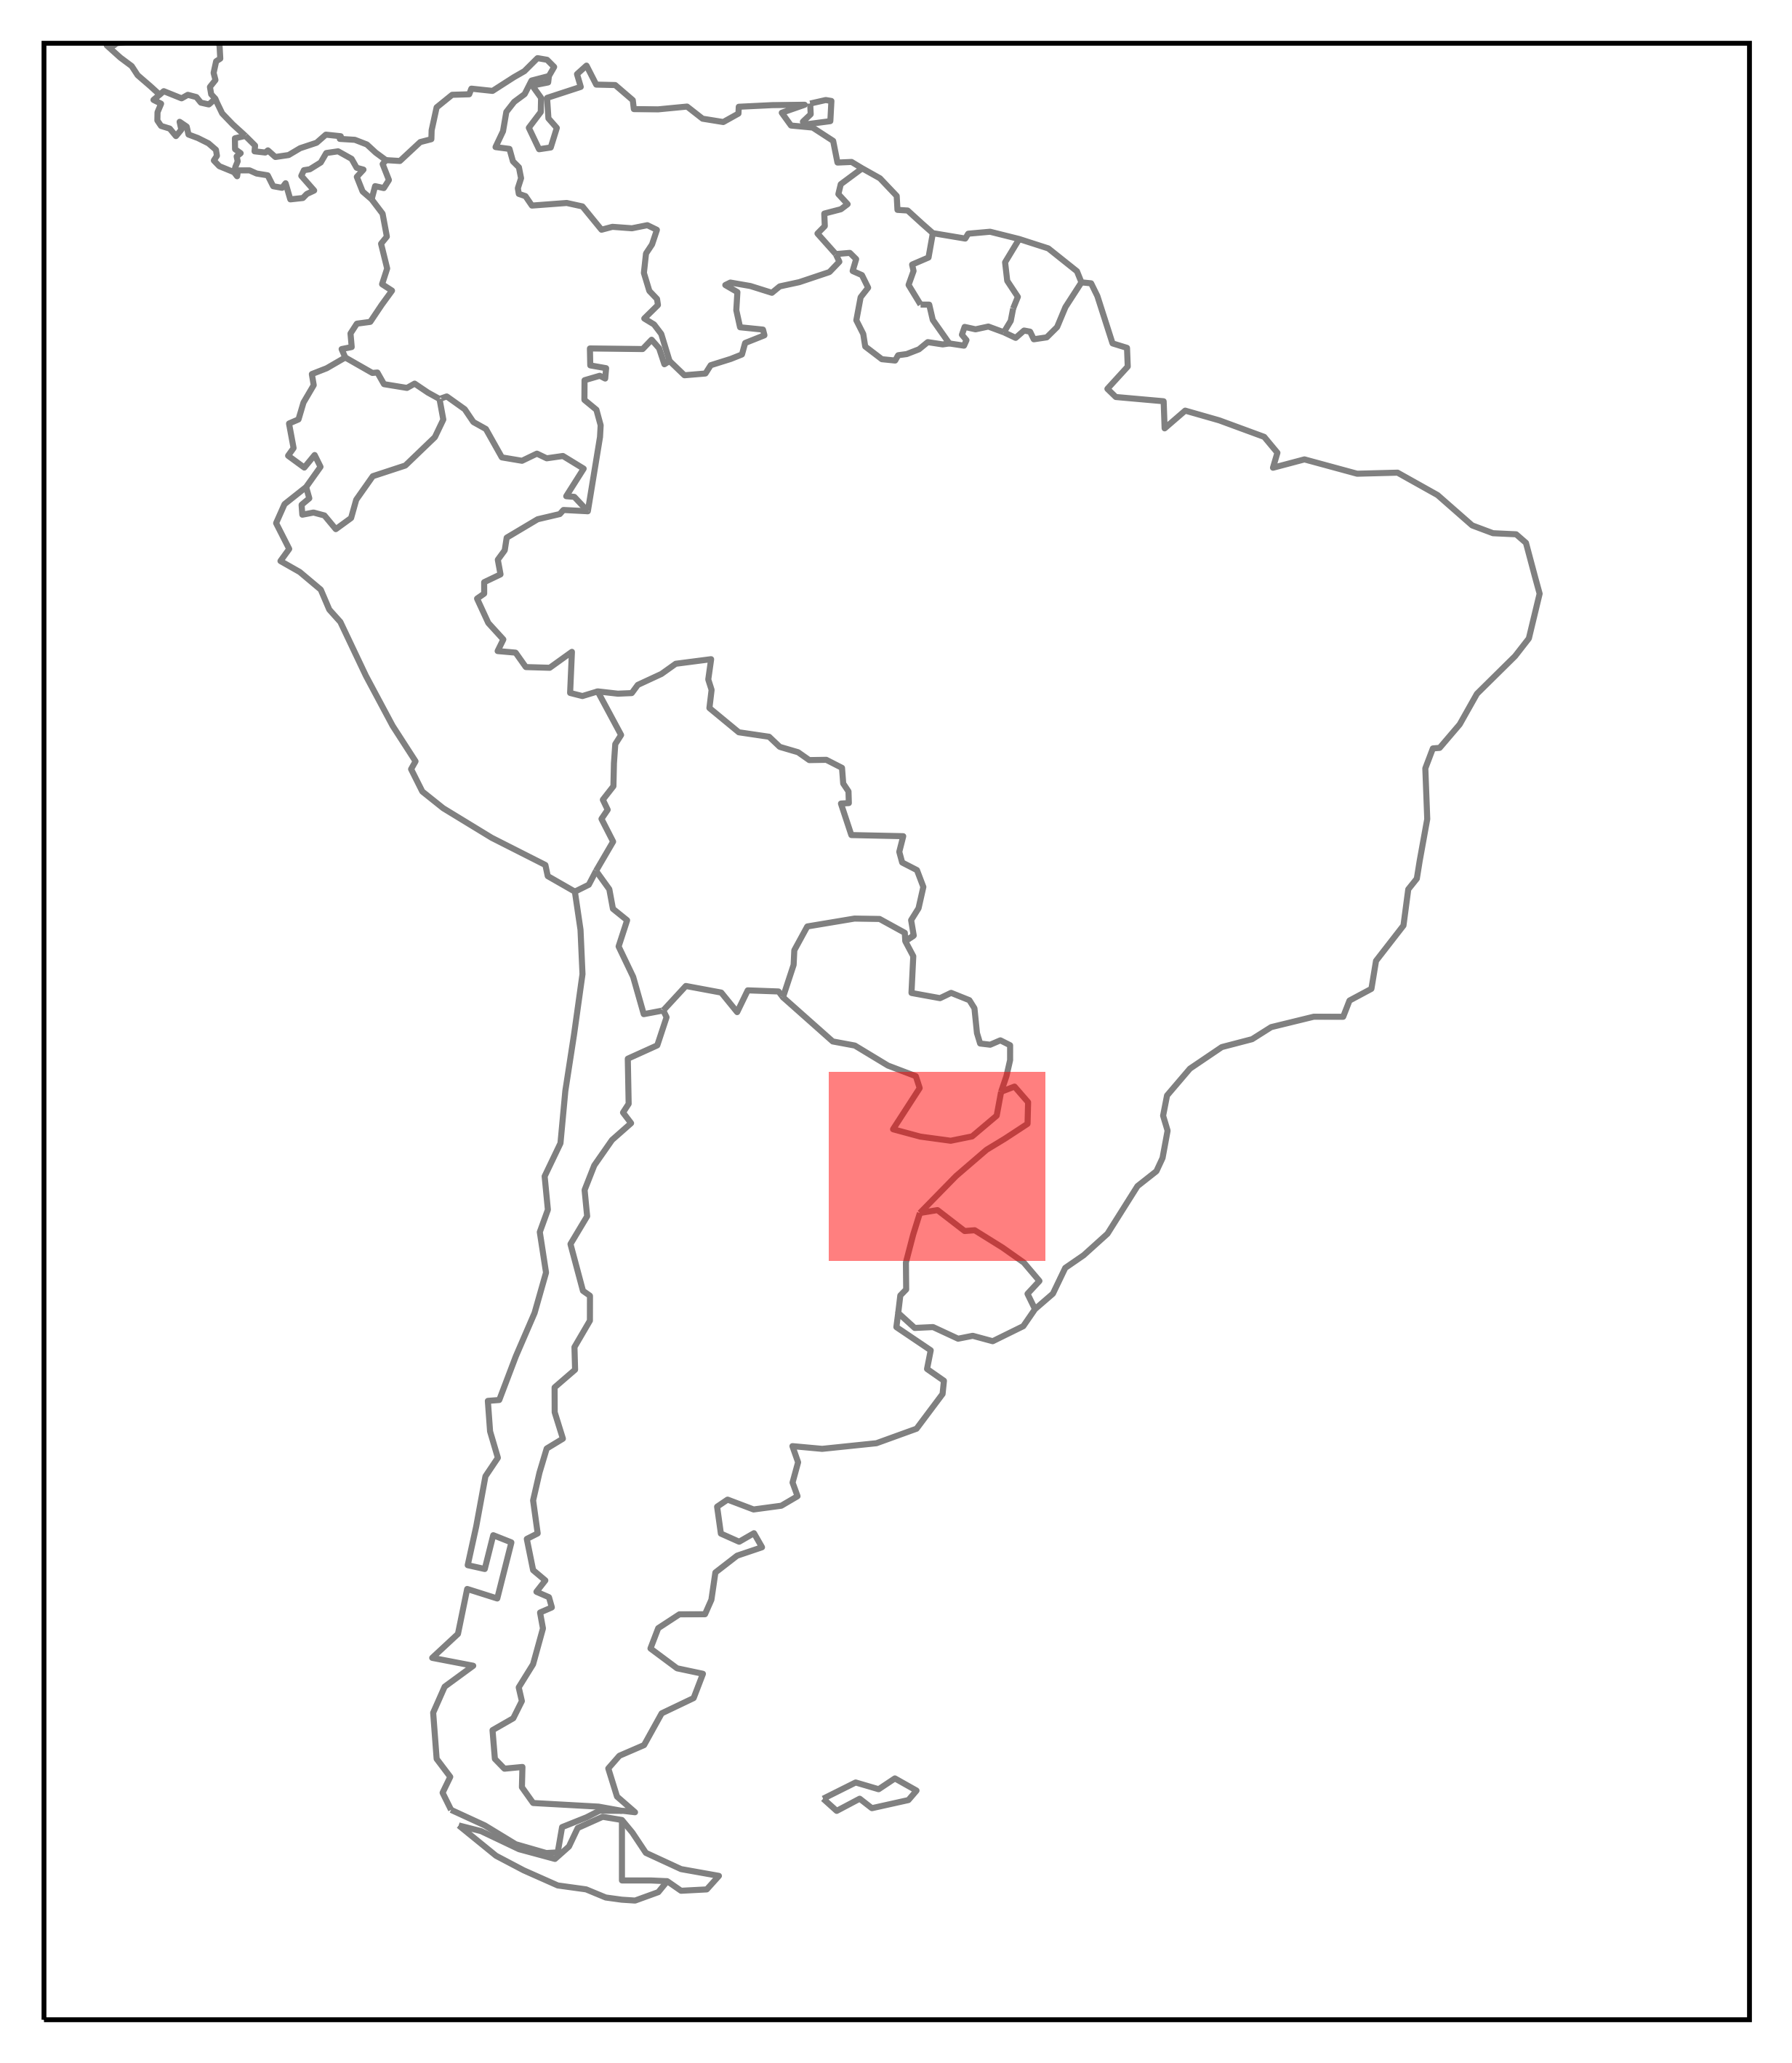

In [167]:
#from matplotlib.patches import Rectangle
#fig1 = plt.figure(figsize = [10, 6], dpi = 600)    
#ax = fig1.add_subplot(111, projection = ccrs.PlateCarree(central_longitude = 0)) #seteo proyeccion

##agrego geometrias de fondo: provincias y paises
#ax.add_feature(cartopy.feature.BORDERS, edgecolor = '0.5')
#ax.add_feature(cartopy.feature.COASTLINE, edgecolor = '0.5')
##seteo ejes
#ax.set_xlim([-90, -27])
#ax.set_ylim([-60, 13])
        
##box = [-61, -53, -32, -25]
#RE=Rectangle((-61,-32),-53--61,-25--32,linewidth=1,linestyle='-' ,zorder=2,\
#edgecolor='none',facecolor='red', alpha = 0.5, transform=ccrs.PlateCarree()) #25 Indicates the latitude interval 25
#ax.add_patch(RE)

#plt.show()

In [170]:
estaciones_ordenadas = {87148: "Roque Saenz Peña", 87166: "Corrientes", 87178: "Posadas Aero",
                        87187: "Oberá", 87270: "Reconquista Aero", 87289: "Paso de los Libres Aero",
                        87393: "Montecaseros", 87395: "Concordia Aero"}

ides_omm_ordenado = list(estaciones_ordenadas.keys())
nombres_ides_omm_ordenado = list(estaciones_ordenadas.values())

####### Manejo de directorios #######


se para en el directorio llamado: /pikachu/datos/nadia.testani/Doctorado/resultados/resultados2021/nubosidad/


se para en el directorio llamado: calibracion en /pikachu/datos/nadia.testani/Doctorado/resultados/resultados2021/nubosidad/




Vuelvo a directorio principal. Ahora el directorio de trabajo es: /home/nadia.testani/Doctorado/codigos/codigos2021/nubosidad


####### Fin de manejo de directorios #######


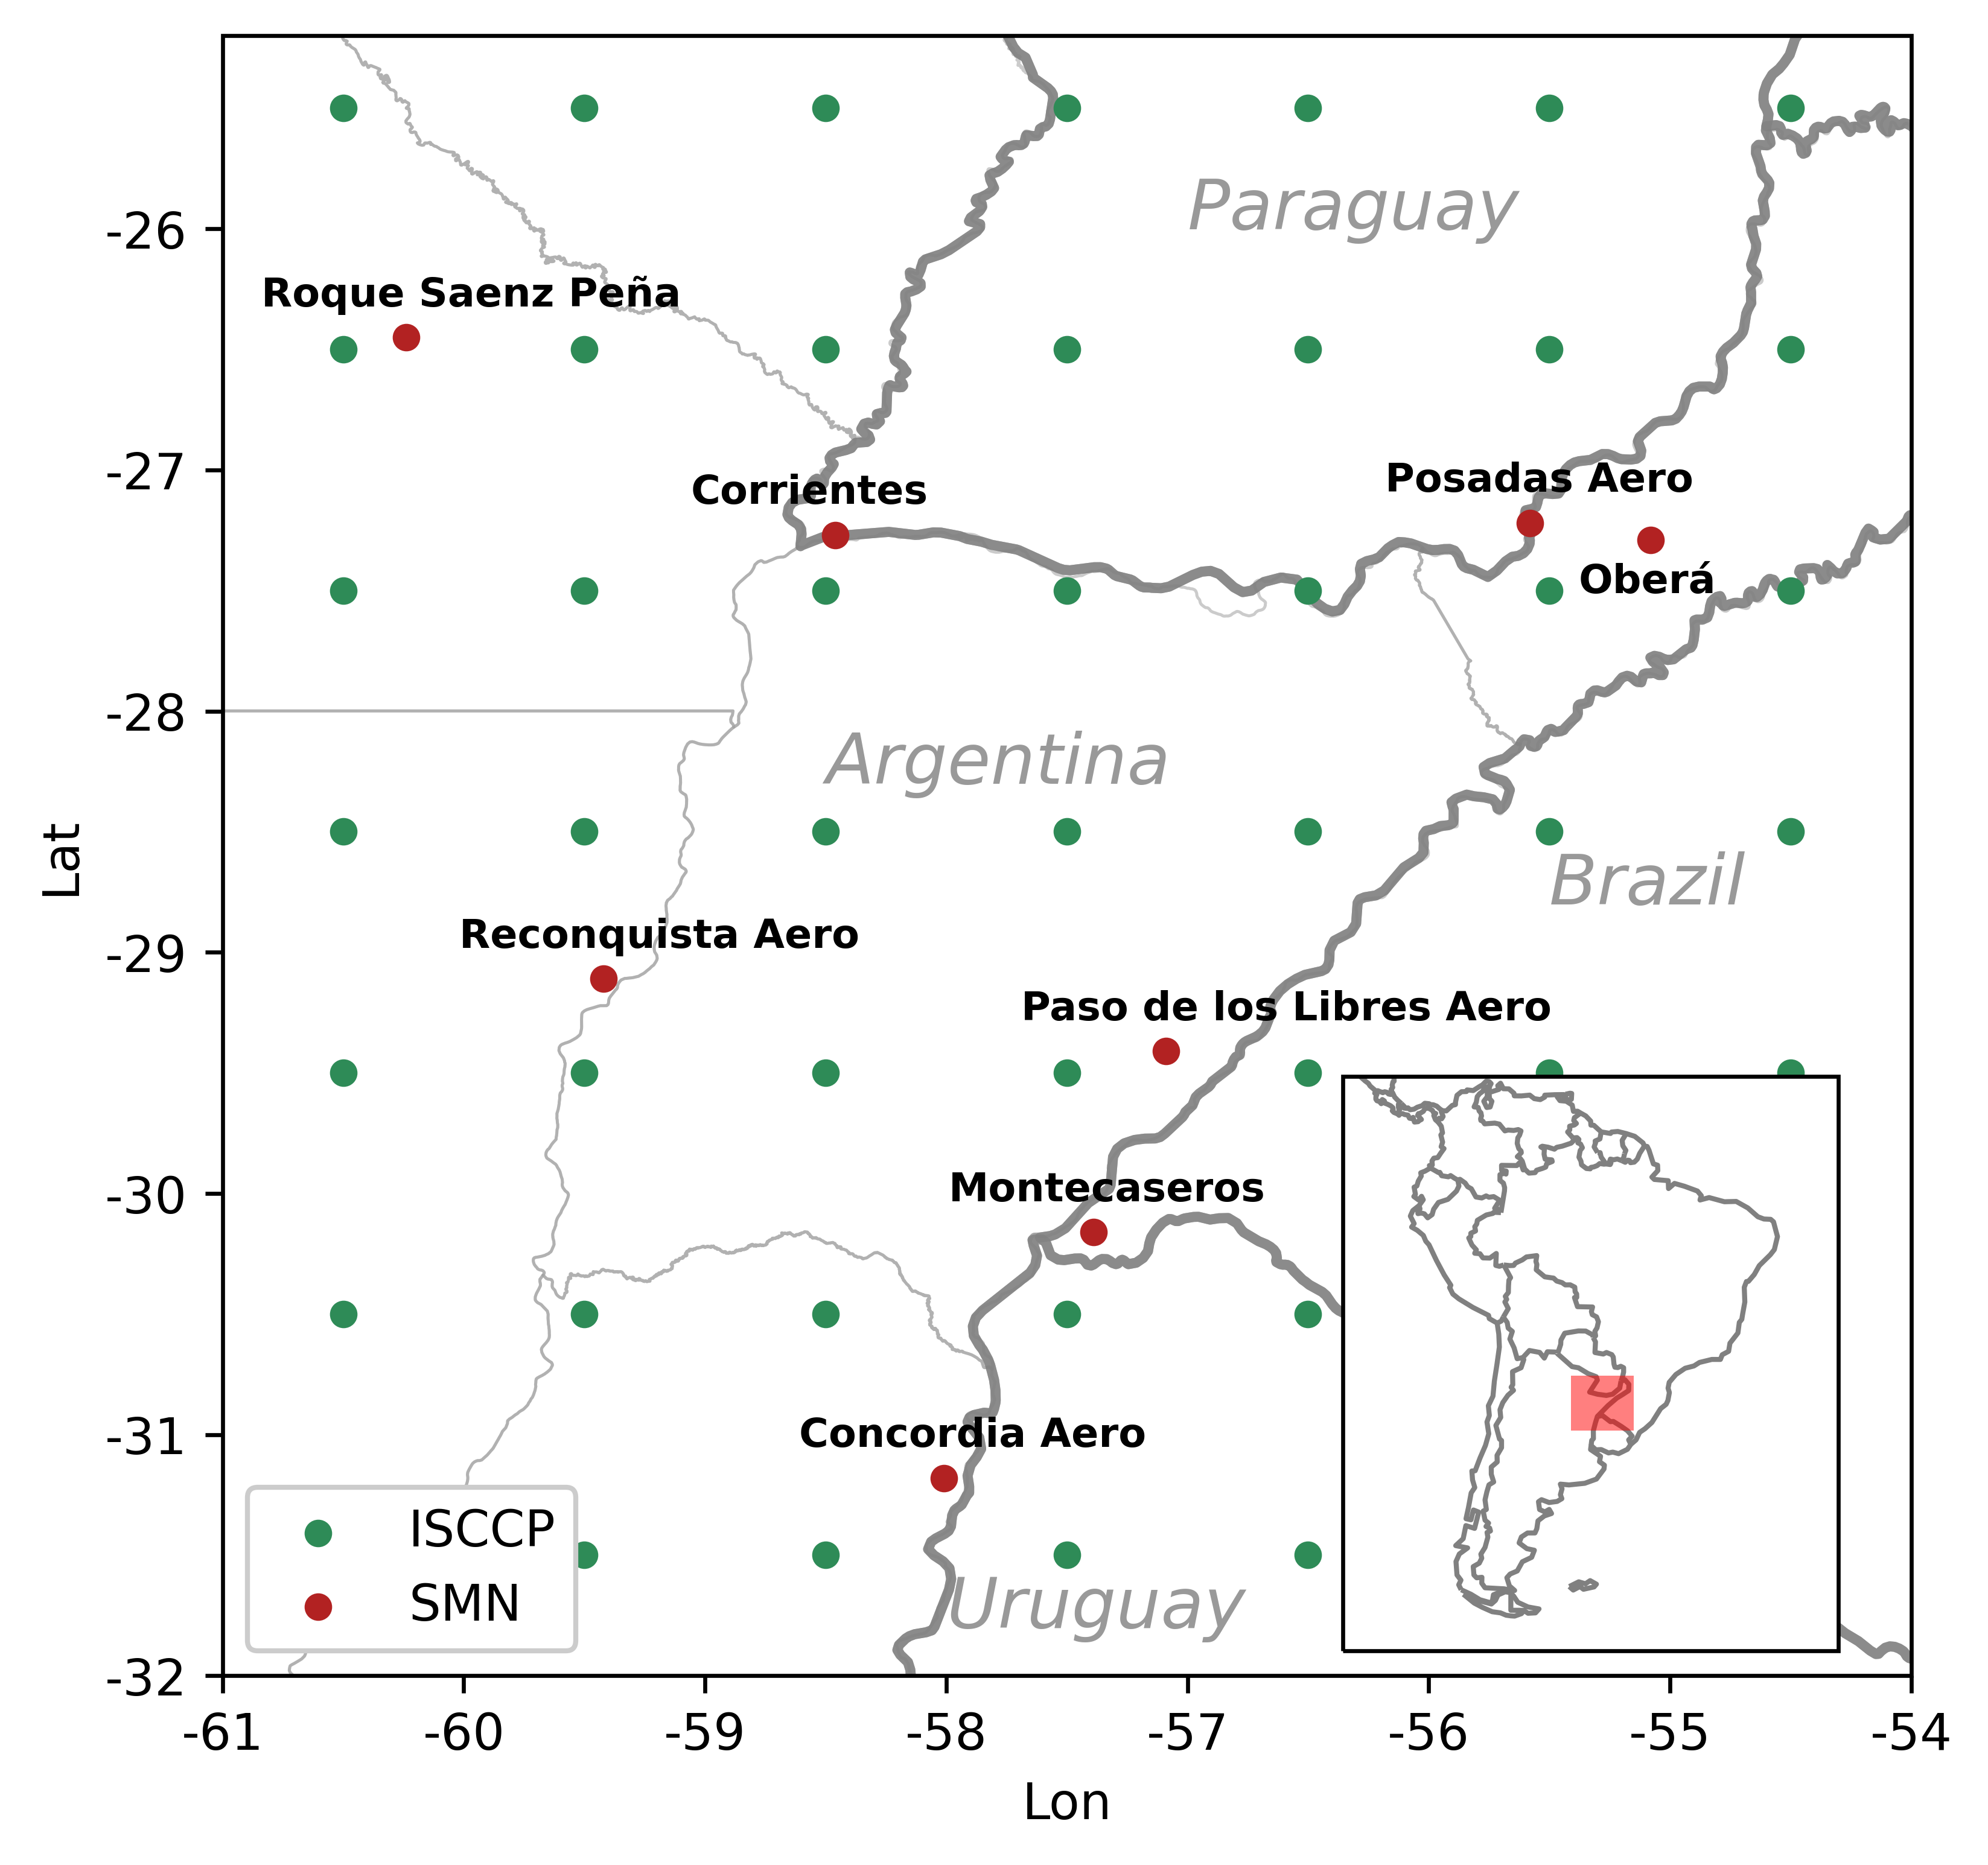

In [173]:
#%% Grafico puntos 

lista_puntos_smn_calibracion = list(estaciones_ordenadas.keys())
#%% Grafico los puntos de grilla satelital junto con puntos de las estaciones del smn
#cargo shapes
shape_paises = df_paises()
shape_provincias = df_provincias()

#grafico
print("####### Manejo de directorios #######")
print("\n")
print(f"se para en el directorio llamado: {ruta_a_resultados}")
os.chdir(ruta_a_resultados) #se para en ruta general de resultados de nubosidad
print("\n")

if "calibracion" not in os.listdir():
    print(f"genera directorio llamado: calibracion en {ruta_a_resultados}")
    os.mkdir("calibracion")
else:
    print(f"se para en el directorio llamado: calibracion en {ruta_a_resultados}")
os.chdir("./calibracion") #se para en nubosidad_observada
print("\n")

#grafico_puntos(lista_puntos_satelital_diario, dict_puntos_smn, lista_puntos_smn_calibracion, shape_paises, shape_provincias)
grafico_puntos_paper(lista_puntos_satelital_diario, dict_puntos_smn, lista_puntos_smn_calibracion, 
                     shape_paises, shape_provincias,nombres_ides_omm_ordenado)

print("\n")
#vuelvo a ruta principal
os.chdir("../../../../../../../../home/nadia.testani/Doctorado/codigos/codigos2021/nubosidad") #codigos/codigos2021/nubosidad")  #VER
cwd = os.getcwd()
print("Vuelvo a directorio principal. Ahora el directorio de trabajo es: {0}".format(cwd))
print("\n")
print("####### Fin de manejo de directorios #######")


In [ ]:
[dict_puntos_smn[punto] for punto in lista_puntos_smn_calibracion]

In [ ]:
lista_puntos_smn_calibracion

In [ ]:
dict(zip(lista_puntos_smn_calibracion, [dict_puntos_smn[punto] for punto in lista_puntos_smn_calibracion]))

In [ ]:
#armo dataframes de las series de los 4 puntos cercanos a cada estacion: en su valor porcentual y pasado a okta,
#y para cada tipo de nube y los guardo
def ejecuto_series_satelital(ID_estacion, dict_puntos_smn, lista_puntos_satelital, data):
    print(f"se para en el directorio llamado: {ruta_a_resultados}calibracion")
    os.chdir(f"{ruta_a_resultados}calibracion")
    print("\n")
    if "datos" not in os.listdir():
        print(f"genera directorio llamado: datos en {ruta_a_resultados}calibracion")
        os.mkdir("datos")
    else:
         print(f"se para en el directorio llamado: datos en {ruta_a_resultados}calibracion")
    os.chdir("./datos")
    
    if str(ID_estacion) not in os.listdir():
        print(f"genera directorio llamado: {ID_estacion} en {ruta_a_resultados}calibracion/datos")
        os.mkdir(str(ID_estacion))
    else:
         print(f"se para en el directorio llamado: {ID_estacion} en {ruta_a_resultados}calibracion/datos")
    os.chdir(f"./{ID_estacion}")
    
    for punto_cercano in puntos_cercanos(ID_estacion, dict_puntos_smn, lista_puntos_satelital, 4): 
        lon = punto_cercano[0]
        lat = punto_cercano[1]
        if f"{lon-360}_{lat}" not in os.listdir():
            print(f"genera directorio llamado: {lon-360}_{lat} en {ruta_a_resultados}calibracion/datos/{ID_estacion}")
            os.mkdir(f"{lon-360}_{lat}") #genero directorio de salida si no esta
        else: 
            print(f"los resultados se guardan en el directorio llamado: {lon-360}_{lat} en {ruta_a_resultados}calibracion/datos/{ID_estacion}")
        os.chdir(f"./{lon-360}_{lat}") #me paro en el directorio de salida 
        data_frame_cldamt_punto = data_frame_oktas(data, lon = lon, lat = lat) #armo series en dataframe de pandas
        #guardo los dataframes como csv
        data_frame_cldamt_punto.to_csv(f"serie_isccp_diario_{lon-360}_{lat}_{ID_estacion}.csv", index_label = "fecha")
        #print(data_frame_cldamt_punto)
        os.chdir("../") 

for estacion in lista_puntos_smn_calibracion:
    ejecuto_series_satelital(estacion, dict_puntos_smn, lista_puntos_satelital_diario, isccp_diario)



In [ ]:
#se hacen los mismos graficos que se hicieron para smn
# directorio para guardar los graficos de nubosidad diaria:

print("####### Manejo de directorios #######")
print("\n")
print(f"se para en el directorio llamado: {ruta_a_resultados}")
os.chdir(ruta_a_resultados) #se para en ruta general de resultados de nubosidad
print("\n")

if "calibracion" not in os.listdir():
    print(f"genera directorio llamado: calibracion en {ruta_a_resultados}")
    os.mkdir("calibracion")
else:
    print(f"se para en el directorio llamado: calibracion en {ruta_a_resultados}")
os.chdir("./calibracion") 
print("\n")

if "series_diario" not in os.listdir():
    print(f"genera directorio llamado: series_diario en {ruta_a_resultados}calibracion")
    os.mkdir("series_diario")
else:
    print(f"se para en el directorio llamado: series_diario en {ruta_a_resultados}calibracion")
os.chdir("./series_diario") 
print("\n")
    
    
print("####### Procesamiento de datos #######")
print("\n")
print("Genera graficos de nubosidad diaria satelital")
print("\n")
def ejecutar_graficos_diarios(id_omm, lon, lat, frecuencias, frecuencia_relativa, df_data_satelital, df_data_smn,
                              fecha_inicio_str, fecha_final_str, 
                              fecha_inicio_str_1, fecha_final_str_1, fecha_inicio_str_2, fecha_final_str_2, 
                              frecuencia_DJF, frecuencia_MAM, frecuencia_JJA, 
                              frecuencia_SON,frecuencia_relativa_DJF, frecuencia_relativa_MAM, 
                              frecuencia_relativa_JJA, frecuencia_relativa_SON, 
                              frecuencia_mensual, frecuencia_relativa_mensual): 

    if str(id_omm) not in os.listdir():
        print(f"genera directorio llamado: {id_omm} en {ruta_a_resultados}calibracion/series_diario")
        os.mkdir(str(id_omm))
    else:
        print(f"se para en el directorio llamado: {id_omm} en {ruta_a_resultados}calibracion/series_diario")
    os.chdir(f"./{id_omm}")  #se para en series_diario, aca se van a guardar los resultados de la estacion id_omm
    print("\n")
    print(f"Ahora el directorio de trabajo es: {os.getcwd()}") 
    print(f"Genera graficos de nubosidad diaria para los puntos cercanos a la estacion: {id_omm}")
    
    if f"{lon}_{lat}" not in os.listdir():
        print(f"genera directorio llamado: {lon}_{lat} en {ruta_a_resultados}calibracion/series_diario/{id_omm}")
        os.mkdir(f"{lon}_{lat}")
    else:
        print(f"se para en el directorio llamado: {lon}_{lat} en {ruta_a_resultados}calibracion/series_diario/{id_omm}")
    os.chdir(f"./{lon}_{lat}") 
    
    scatter(lon,lat, df_data_satelital, fecha_inicio_str, fecha_final_str)
    plt.close()
    
    ##histogramas:
    #histograma(lon,lat, df_data_satelital, fecha_inicio_str, fecha_final_str, variable = "cldamt_oktas", estaciones = False, meses = False)
    #plt.close()
    #histograma(lon,lat, agrupo_data(df_data_satelital, 1), fecha_inicio_str, fecha_final_str, variable = "cldamt_oktas", estaciones = False, meses = False, agrupo = 1)
    #plt.close()
    #histograma(lon,lat, agrupo_data(df_data_satelital, 2), fecha_inicio_str, fecha_final_str, variable = "cldamt_oktas", estaciones = False, meses = False, agrupo = 2)
    #plt.close()
    
    #histograma(lon,lat, df_data_satelital, fecha_inicio_str, fecha_final_str, variable = "cldamt_oktas", estaciones = True, meses = False)
    #plt.close()
    #histograma(lon,lat, agrupo_data(df_data_satelital, 1), fecha_inicio_str, fecha_final_str, variable = "cldamt_oktas", estaciones = True, meses = False, agrupo = 1)
    #plt.close()
    #histograma(lon,lat, agrupo_data(df_data_satelital, 2), fecha_inicio_str, fecha_final_str, variable = "cldamt_oktas", estaciones = True, meses = False, agrupo = 2)
    #plt.close()
    
    #histograma(lon,lat, df_data_satelital, fecha_inicio_str, fecha_final_str, variable = "cldamt_oktas", estaciones = False, meses = True)
    #plt.close()
    #histograma(lon,lat, agrupo_data(df_data_satelital, 1), fecha_inicio_str, fecha_final_str, variable = "cldamt_oktas", estaciones = False, meses = True, agrupo = 1)
    #plt.close()
    #histograma(lon,lat, agrupo_data(df_data_satelital, 2), fecha_inicio_str, fecha_final_str, variable = "cldamt_oktas", estaciones = False, meses = True, agrupo = 2)
    #plt.close()
    
    ##stackplots:
    stackplot(frecuencias, lon, lat, df_data_satelital, fecha_inicio_str, fecha_final_str)
    plt.close() 
    ###
    stackplot(frecuencias = agrupo_frecuencias(frecuencias, 1), lon = lon, lat = lat, df_data = df_data_satelital, 
              fecha_inicio_str = fecha_inicio_str, fecha_final_str = fecha_final_str, 
              colores = f_paletas_colores.paleta_5_colores, agrupo = 1)
    plt.close() 
    
    stackplot(frecuencias = agrupo_frecuencias(frecuencias, 2), lon = lon, lat = lat, df_data = df_data_satelital, 
              fecha_inicio_str = fecha_inicio_str, fecha_final_str = fecha_final_str, 
              colores = f_paletas_colores.paleta_3_colores, agrupo = 2)
    plt.close() 
    
    ###
    stackplot(frecuencias=frecuencias, lon = lon, lat = lat, df_data=df_data_satelital, 
              fecha_inicio_str=fecha_inicio_str, fecha_final_str=fecha_final_str, 
              etiqueta_datos_faltantes = False, frecuencias_DJF = frecuencia_DJF, 
              frecuencias_MAM=frecuencia_MAM, frecuencias_JJA=frecuencia_JJA, 
              frecuencias_SON=frecuencia_SON, estaciones = True)
    plt.close()
    
    ###
    stackplot(frecuencias=agrupo_frecuencias(frecuencias, 1), lon = lon, lat = lat, df_data=df_data_satelital, 
              fecha_inicio_str=fecha_inicio_str, fecha_final_str=fecha_final_str, 
              colores = f_paletas_colores.paleta_5_colores, etiqueta_datos_faltantes = False, 
              frecuencias_DJF = agrupo_frecuencias(frecuencia_DJF,1), 
              frecuencias_MAM = agrupo_frecuencias(frecuencia_MAM,1),
              frecuencias_JJA = agrupo_frecuencias(frecuencia_JJA,1),
              frecuencias_SON = agrupo_frecuencias(frecuencia_SON,1), estaciones = True, agrupo = 1)
    plt.close()
    stackplot(frecuencias=agrupo_frecuencias(frecuencias, 2), lon = lon, lat = lat, df_data=df_data_satelital,
              fecha_inicio_str=fecha_inicio_str, fecha_final_str=fecha_final_str, 
              colores = f_paletas_colores.paleta_3_colores,etiqueta_datos_faltantes = False, 
              frecuencias_DJF = agrupo_frecuencias(frecuencia_DJF,2),
              frecuencias_MAM = agrupo_frecuencias(frecuencia_MAM,2),
              frecuencias_JJA = agrupo_frecuencias(frecuencia_JJA,2),
              frecuencias_SON = agrupo_frecuencias(frecuencia_SON,2), estaciones = True, agrupo = 2)
    plt.close()
    
    #mensual
    stackplot(frecuencias=frecuencia_mensual, lon = lon, lat = lat, df_data=df_data_satelital, 
              fecha_inicio_str=fecha_inicio_str, fecha_final_str=fecha_final_str, 
              etiqueta_datos_faltantes = False, frecuencias_DJF = frecuencia_relativa_DJF, 
              frecuencias_MAM=frecuencia_relativa_MAM, frecuencias_JJA=frecuencia_relativa_JJA,
              frecuencias_SON=frecuencia_relativa_SON, estaciones = False,  meses = True, 
              freq_relativa = False)
    plt.close()
    
    stackplot(frecuencias=agrupo_frecuencias(frecuencia_mensual,1), lon = lon, lat = lat, df_data=df_data_satelital, 
              fecha_inicio_str=fecha_inicio_str, fecha_final_str=fecha_final_str, 
              colores = f_paletas_colores.paleta_5_colores,
              etiqueta_datos_faltantes = False, frecuencias_DJF = frecuencia_relativa_DJF, 
              frecuencias_MAM=frecuencia_relativa_MAM, frecuencias_JJA=frecuencia_relativa_JJA,
              frecuencias_SON=frecuencia_relativa_SON, estaciones = False,  meses = True, 
              freq_relativa = False, agrupo = 1)
    plt.close()
    
    stackplot(frecuencias=agrupo_frecuencias(frecuencia_mensual,2), lon = lon, lat = lat, df_data=df_data_satelital, 
              fecha_inicio_str=fecha_inicio_str, fecha_final_str=fecha_final_str, 
              colores = f_paletas_colores.paleta_3_colores,
              etiqueta_datos_faltantes = False, frecuencias_DJF = frecuencia_relativa_DJF, 
              frecuencias_MAM=frecuencia_relativa_MAM, frecuencias_JJA=frecuencia_relativa_JJA,
              frecuencias_SON=frecuencia_relativa_SON, estaciones = False,  meses = True, 
              freq_relativa = False, agrupo = 2)
    plt.close()
    ###
    
    ##stackplots relativos:
    stackplot(frecuencias = frecuencia_relativa, lon = lon, lat = lat, df_data = df_data_satelital, 
              fecha_inicio_str = fecha_inicio_str, fecha_final_str = fecha_final_str, freq_relativa = True)
    plt.close() 
    ##
    stackplot(frecuencias = agrupo_frecuencias(frecuencia_relativa, 1), lon = lon, lat = lat, df_data = df_data_satelital, 
              fecha_inicio_str = fecha_inicio_str, fecha_final_str = fecha_final_str, 
              colores = f_paletas_colores.paleta_5_colores, agrupo = 1, freq_relativa = True)
    plt.close() 
    
    stackplot(frecuencias = agrupo_frecuencias(frecuencia_relativa, 2), lon = lon, lat = lat, df_data = df_data_satelital, 
              fecha_inicio_str = fecha_inicio_str, fecha_final_str = fecha_final_str, 
              colores = f_paletas_colores.paleta_3_colores, agrupo = 2, freq_relativa = True)
    plt.close() 
    
    ###
    stackplot(frecuencias=frecuencia_relativa, lon = lon, lat = lat, df_data=df_data_satelital, 
              fecha_inicio_str=fecha_inicio_str, fecha_final_str=fecha_final_str, 
              etiqueta_datos_faltantes = False, frecuencias_DJF = frecuencia_relativa_DJF, 
              frecuencias_MAM=frecuencia_relativa_MAM, frecuencias_JJA=frecuencia_relativa_JJA,
              frecuencias_SON=frecuencia_relativa_SON, estaciones = True, freq_relativa = True)
    plt.close()
    
    ###
    stackplot(frecuencias=agrupo_frecuencias(frecuencia_relativa, 1), lon = lon, lat = lat, df_data=df_data_satelital, 
              fecha_inicio_str=fecha_inicio_str, fecha_final_str=fecha_final_str, 
              colores = f_paletas_colores.paleta_5_colores, etiqueta_datos_faltantes = False, 
              frecuencias_DJF = agrupo_frecuencias(frecuencia_relativa_DJF,1), 
              frecuencias_MAM = agrupo_frecuencias(frecuencia_relativa_MAM,1),
              frecuencias_JJA = agrupo_frecuencias(frecuencia_relativa_JJA,1),
              frecuencias_SON = agrupo_frecuencias(frecuencia_relativa_SON,1), 
              estaciones = True, agrupo = 1, freq_relativa = True)
    plt.close()
    stackplot(frecuencias=agrupo_frecuencias(frecuencia_relativa, 2), lon = lon, lat = lat, df_data=df_data_satelital,
              fecha_inicio_str=fecha_inicio_str, fecha_final_str=fecha_final_str, 
              colores = f_paletas_colores.paleta_3_colores,etiqueta_datos_faltantes = False, 
              frecuencias_DJF = agrupo_frecuencias(frecuencia_relativa_DJF,2),
              frecuencias_MAM = agrupo_frecuencias(frecuencia_relativa_MAM,2),
              frecuencias_JJA = agrupo_frecuencias(frecuencia_relativa_JJA,2),
              frecuencias_SON = agrupo_frecuencias(frecuencia_relativa_SON,2), 
              estaciones = True, agrupo = 2, freq_relativa = True)
    plt.close()
    
    #mensual
    stackplot(frecuencias=frecuencia_relativa_mensual, lon = lon, lat = lat, df_data=df_data_satelital, 
              fecha_inicio_str=fecha_inicio_str, fecha_final_str=fecha_final_str, 
              etiqueta_datos_faltantes = False, frecuencias_DJF = frecuencia_relativa_DJF, 
              frecuencias_MAM=frecuencia_relativa_MAM, frecuencias_JJA=frecuencia_relativa_JJA,
              frecuencias_SON=frecuencia_relativa_SON, estaciones = False,  meses = True, 
              freq_relativa = True)
    plt.close()
    
    stackplot(frecuencias=agrupo_frecuencias(frecuencia_relativa_mensual,1), lon = lon, lat = lat, df_data=df_data_satelital, 
              fecha_inicio_str=fecha_inicio_str, fecha_final_str=fecha_final_str, 
              colores = f_paletas_colores.paleta_5_colores,
              etiqueta_datos_faltantes = False, frecuencias_DJF = frecuencia_relativa_DJF, 
              frecuencias_MAM=frecuencia_relativa_MAM, frecuencias_JJA=frecuencia_relativa_JJA,
              frecuencias_SON=frecuencia_relativa_SON, estaciones = False,  meses = True, 
              freq_relativa = True, agrupo = 1)
    plt.close()
    
    stackplot(frecuencias=agrupo_frecuencias(frecuencia_relativa_mensual,2), lon = lon, lat = lat, df_data=df_data_satelital, 
              fecha_inicio_str=fecha_inicio_str, fecha_final_str=fecha_final_str, 
              colores = f_paletas_colores.paleta_3_colores,
              etiqueta_datos_faltantes = False, frecuencias_DJF = frecuencia_relativa_DJF, 
              frecuencias_MAM=frecuencia_relativa_MAM, frecuencias_JJA=frecuencia_relativa_JJA,
              frecuencias_SON=frecuencia_relativa_SON, estaciones = False,  meses = True, 
              freq_relativa = True, agrupo = 2)
    plt.close()
    ###
    
    ##barplots:
    #barplot_oktas_separadas(frecuencias = frecuencias, lon = lon, lat = lat, 
     #                       fecha_inicio_str = fecha_inicio_str, fecha_final_str = fecha_final_str)
    #plt.close()
    
    #histogramas_partidos:
    #histogramas_partidos(lon, lat, df_data_satelital, fecha_inicio_str_1, fecha_final_str_1, fecha_inicio_str_2, 
     #                    fecha_final_str_2, variable = "cldamt_oktas", estaciones = False, meses = False)
    #plt.close()
    #histogramas_partidos(lon, lat, agrupo_data(df_data_satelital, 1), fecha_inicio_str_1, fecha_final_str_1, 
    #                     fecha_inicio_str_2, fecha_final_str_2, variable = "cldamt_oktas", 
    #                     estaciones = False, meses = False, agrupo = 1)
    #plt.close()
    #histogramas_partidos(lon, lat, agrupo_data(df_data_satelital, 2), fecha_inicio_str_1, fecha_final_str_1, 
    #                     fecha_inicio_str_2, fecha_final_str_2, variable = "cldamt_oktas", 
    #                     estaciones = False, meses = False, agrupo = 2)
    #plt.close()
    ###histogramas_partidos(lon, lat, df_data, fecha_inicio_str_1, fecha_final_str_1, fecha_inicio_str_2, fecha_final_str_2, fecha_inicio_str_0 = fecha_inicio_str_0, fecha_final_str_0 = fecha_final_str_0, variable = "cldamt_oktas",                     estaciones = False, meses = False)
    ###plt.close() 
    ###histogramas_partidos(lon, lat, agrupo_data(df_data, 1), fecha_inicio_str_1, fecha_final_str_1, fecha_inicio_str_2, fecha_final_str_2, fecha_inicio_str_0 = fecha_inicio_str_0, fecha_final_str_0 = fecha_final_str_0, variable = "nub", estaciones = False, meses = False, agrupo=1)
    ###plt.close() 
    ###histogramas_partidos(lon, lat, agrupo_data(df_data, 2), fecha_inicio_str_1, fecha_final_str_1, fecha_inicio_str_2, fecha_final_str_2, fecha_inicio_str_0 = fecha_inicio_str_0, fecha_final_str_0 = fecha_final_str_0, variable = "nub", estaciones = False, meses = False, agrupo=2)
    ###plt.close() 

    #histogramas_partidos(lon, lat, df_data_satelital, fecha_inicio_str_1, fecha_final_str_1, fecha_inicio_str_2, 
    #                     fecha_final_str_2, variable = "cldamt_oktas", estaciones = True, meses = False)
    #plt.close()
    #histogramas_partidos(lon, lat, agrupo_data(df_data_satelital, 1), fecha_inicio_str_1, fecha_final_str_1, 
    #                     fecha_inicio_str_2, fecha_final_str_2, variable = "cldamt_oktas", 
    #                     estaciones = True, meses = False, agrupo = 1)
    #plt.close()
    #histogramas_partidos(lon, lat, agrupo_data(df_data_satelital, 2), fecha_inicio_str_1, fecha_final_str_1, 
    #                     fecha_inicio_str_2, fecha_final_str_2, variable = "cldamt_oktas", 
    #                     estaciones = True, meses = False, agrupo = 2)
    #plt.close()
    
    ####histogramas_partidos(lon, lat, df_data, fecha_inicio_str_1, fecha_final_str_1, fecha_inicio_str_2, fecha_final_str_2, fecha_inicio_str_0 = fecha_inicio_str_0, fecha_final_str_0 = fecha_final_str_0, variable = "nub", estaciones = True, meses = False)
    ####plt.close()
    ####histogramas_partidos(lon, lat, agrupo_data(df_data, 1), fecha_inicio_str_1, fecha_final_str_1, fecha_inicio_str_2, fecha_final_str_2, fecha_inicio_str_0 = fecha_inicio_str_0, fecha_final_str_0 = fecha_final_str_0, variable = "nub", estaciones = True, meses = False, agrupo = 1)
    ####plt.close()
    ####histogramas_partidos(lon, lat, agrupo_data(df_data, 2), fecha_inicio_str_1, fecha_final_str_1, fecha_inicio_str_2, fecha_final_str_2, fecha_inicio_str_0 = fecha_inicio_str_0, fecha_final_str_0 = fecha_final_str_0, variable = "nub", estaciones = True, meses = False, agrupo = 2)
    ####plt.close()
    
    #histogramas_partidos(lon, lat, df_data_satelital, fecha_inicio_str_1, fecha_final_str_1, fecha_inicio_str_2,
    #                     fecha_final_str_2, variable = "cldamt_oktas", estaciones = False, meses = True)
    #plt.close()
    #histogramas_partidos(lon, lat, agrupo_data(df_data_satelital, 1), fecha_inicio_str_1, fecha_final_str_1, 
    #                     fecha_inicio_str_2, fecha_final_str_2, variable = "cldamt_oktas", 
    #                     estaciones = False, meses = True, agrupo = 1)
    #plt.close()
    #histogramas_partidos(lon, lat, agrupo_data(df_data_satelital, 2), fecha_inicio_str_1, fecha_final_str_1, 
    #                     fecha_inicio_str_2, fecha_final_str_2, variable = "cldamt_oktas", 
    #                     estaciones = False, meses = True, agrupo = 2)
    #plt.close()
    
    ####histogramas_partidos(lon, lat, df_data, fecha_inicio_str_1, fecha_final_str_1, fecha_inicio_str_2, fecha_final_str_2, fecha_inicio_str_0 = fecha_inicio_str_0, fecha_final_str_0 = fecha_final_str_0, variable = "nub", estaciones = False, meses = True)
    ####plt.close()
    ####histogramas_partidos(lon, lat, agrupo_data(df_data, 1), fecha_inicio_str_1, fecha_final_str_1, fecha_inicio_str_2, fecha_final_str_2, fecha_inicio_str_0 = fecha_inicio_str_0, fecha_final_str_0 = fecha_final_str_0, variable = "nub", estaciones = False, meses = True, agrupo = 1)
    ####plt.close()
    ####histogramas_partidos(lon, lat, agrupo_data(df_data, 2), fecha_inicio_str_1, fecha_final_str_1, fecha_inicio_str_2, fecha_final_str_2, fecha_inicio_str_0 = fecha_inicio_str_0, fecha_final_str_0 = fecha_final_str_0, variable = "nub", estaciones = False, meses = True, agrupo = 2)
    ####plt.close()
    
    #histogramas smn y satelital
    #histograma_oktas_sat_smn(id_omm = id_omm, df_data_smn = df_data_smn, fecha_inicio_str = fecha_inicio_str,
    #                         fecha_final_str = fecha_final_str, data_frame_cldamt_punto = df_data_satelital, 
    #                         lon = lon, lat = lat, estaciones = False, meses = False)
    
    #histograma_oktas_sat_smn(id_omm = id_omm, df_data_smn = f_procesamiento_smn.agrupo_data(df_data_smn, 1), 
    #                         fecha_inicio_str = fecha_inicio_str,fecha_final_str = fecha_final_str, 
    #                         data_frame_cldamt_punto = agrupo_data(df_data_satelital, 1), 
    #                         lon = lon, lat = lat, estaciones = False, meses = False, agrupo = 1)
    
    #histograma_oktas_sat_smn(id_omm = id_omm, df_data_smn = f_procesamiento_smn.agrupo_data(df_data_smn, 2), 
    #                         fecha_inicio_str = fecha_inicio_str,fecha_final_str = fecha_final_str, 
    #                         data_frame_cldamt_punto = agrupo_data(df_data_satelital, 2), 
    #                         lon = lon, lat = lat, estaciones = False, meses = False, agrupo = 2)
    
    #histograma_oktas_sat_smn(id_omm = id_omm, df_data_smn = df_data_smn, fecha_inicio_str = fecha_inicio_str,
    #                         fecha_final_str = fecha_final_str, data_frame_cldamt_punto = df_data_satelital, 
    #                         lon = lon, lat = lat, estaciones = True, meses = False)
    
    #histograma_oktas_sat_smn(id_omm = id_omm, df_data_smn = f_procesamiento_smn.agrupo_data(df_data_smn, 1), 
    #                         fecha_inicio_str = fecha_inicio_str,fecha_final_str = fecha_final_str, 
    #                         data_frame_cldamt_punto = agrupo_data(df_data_satelital, 1), 
    #                         lon = lon, lat = lat, estaciones = True, meses = False, agrupo = 1)
    #
    #histograma_oktas_sat_smn(id_omm = id_omm, df_data_smn = f_procesamiento_smn.agrupo_data(df_data_smn, 2), 
    #                         fecha_inicio_str = fecha_inicio_str,fecha_final_str = fecha_final_str, 
    #                         data_frame_cldamt_punto = agrupo_data(df_data_satelital, 2), 
    #                         lon = lon, lat = lat, estaciones = True, meses = False, agrupo = 2)
    
    #histograma_oktas_sat_smn(id_omm = id_omm, df_data_smn = df_data_smn, fecha_inicio_str = fecha_inicio_str,
    #                         fecha_final_str = fecha_final_str, data_frame_cldamt_punto = df_data_satelital, 
    #                         lon = lon, lat = lat, estaciones = False, meses = True)
    
    #histograma_oktas_sat_smn(id_omm = id_omm, df_data_smn = f_procesamiento_smn.agrupo_data(df_data_smn, 1), 
    #                         fecha_inicio_str = fecha_inicio_str,fecha_final_str = fecha_final_str, 
    #                         data_frame_cldamt_punto = agrupo_data(df_data_satelital, 1), 
    #                         lon = lon, lat = lat, estaciones = False, meses = True, agrupo = 1)
    #
    #histograma_oktas_sat_smn(id_omm = id_omm, df_data_smn = f_procesamiento_smn.agrupo_data(df_data_smn, 2), 
    #                         fecha_inicio_str = fecha_inicio_str,fecha_final_str = fecha_final_str, 
    #                         data_frame_cldamt_punto = agrupo_data(df_data_satelital, 2), 
    #                         lon = lon, lat = lat, estaciones = False, meses = True, agrupo = 2)
    
    #generar_tabla_contingencia(ID_estacion = id_omm, data_frame_smn = df_data_smn, 
    #                           fecha_inicio_str = fecha_inicio_str, fecha_final_str = fecha_final_str, 
    #                           data_frame_cldamt_punto = df_data_satelital,
    #                           lon = lon, lat = lat, alpha = 0.05, estaciones = False, meses = False)
    
    #generar_tabla_contingencia(ID_estacion = id_omm, data_frame_smn = df_data_smn, 
    #                           fecha_inicio_str = fecha_inicio_str, fecha_final_str = fecha_final_str, 
    #                           data_frame_cldamt_punto = df_data_satelital,
    #                           lon = lon, lat = lat, alpha = 0.05, estaciones = True, meses = False)
    
    ##vuelvo a directorio de trabajo de series general: series_diario
    print("\n")
    os.chdir("../../")
    print(f"Vuelvo a un directorio anterior. Ahora el directorio de trabajo es: {os.getcwd()}") 
    

for id_omm in lista_puntos_smn_calibracion:
    
    #FOR SOBRE LOS PUNTOS ALREDEDOR DE ESE ID_OMM
    df_data_smn = datos_smn[id_omm]
    
    for punto_cercano in puntos_cercanos(id_omm, dict_puntos_smn, lista_puntos_satelital_diario, 4): 
        if "datos" not in os.listdir():
            print(f"genera directorio llamado: datos en {ruta_a_resultados}calibracion/series_diario")
            os.mkdir("datos")
        else:
            print(f"se para en el directorio llamado: datos en {ruta_a_resultados}calibracion/series_diario")
        os.chdir("./datos") #se para en datos, aca se van a guardar los resultados 
        print("\n")    
        lon = punto_cercano[0]-360
        lat = punto_cercano[1]
        
        df_data_satelital = pd.read_csv(f"{ruta_a_resultados}calibracion/datos/{id_omm}/{lon}_{lat}/serie_isccp_diario_{lon}_{lat}_{id_omm}.csv",
                                        index_col = "fecha")
        df_data_satelital.index = pd.to_datetime(df_data_satelital.index)
        
        if f"frecuencia_anual_dias_{lon}_{lat}.csv" not in os.listdir():
            print(f"genera un archivo: frecuencia_anual_dias_{lon}_{lat}.csv en {ruta_a_resultados}calibracion/series_diario/datos")
            frecuencia = frecuencia_oktas_por_anio(lon,lat, df_data_satelital, ".")[0]
        else:
            frecuencia = pd.read_csv(f"frecuencia_anual_dias_{lon}_{lat}.csv", index_col="fecha")
        
        if f"frecuencia_mensual_en_dias_{lon}_{lat}.csv" not in os.listdir():
            print(f"genera un archivo: frecuencia_mensual_en_dias_{lon}_{lat}.csv en {ruta_a_resultados}calibracion/series_diario/datos")
            frecuencia_mensual = frecuencia_oktas_por_mes(lon, lat, df_data_satelital, ".")[0]
        else:
            frecuencia_mensual = pd.read_csv(f"frecuencia_mensual_en_dias_{lon}_{lat}.csv", index_col="fecha")
            
        if f"frecuencia_anual_DJF_dias_{lon}_{lat}.csv" not in os.listdir():
            print(f"genera un archivo: frecuencia_anual_DJF_dias_{lon}_{lat}.csv en {ruta_a_resultados}calibracion/series_diario/datos")
            frecuencia_DJF = frecuencia_oktas_por_anio_estaciones(lon,lat, df_data_satelital, ".", "DJF")[0]
        else:
            frecuencia_DJF = pd.read_csv(f"frecuencia_anual_DJF_dias_{lon}_{lat}.csv", index_col="fecha")

        if f"frecuencia_anual_MAM_dias_{lon}_{lat}.csv" not in os.listdir():
            print(f"genera un archivo: frecuencia_anual_MAM_dias_{lon}_{lat}.csv en {ruta_a_resultados}calibracion/series_diario/datos")
            frecuencia_MAM = frecuencia_oktas_por_anio_estaciones(lon,lat, df_data_satelital, ".", "MAM")[0]
        else:
            frecuencia_MAM = pd.read_csv(f"frecuencia_anual_MAM_dias_{lon}_{lat}.csv", index_col="fecha")

        if f"frecuencia_anual_JJA_dias_{lon}_{lat}.csv" not in os.listdir():
            print(f"genera un archivo: frecuencia_anual_JJA_dias_{lon}_{lat}.csv en {ruta_a_resultados}calibracion/series_diario/datos")
            frecuencia_JJA = frecuencia_oktas_por_anio_estaciones(lon,lat, df_data_satelital, ".", "JJA")[0]
        else:
            frecuencia_JJA = pd.read_csv(f"frecuencia_anual_JJA_dias_{lon}_{lat}.csv", index_col="fecha")

        if f"frecuencia_anual_SON_dias_{lon}_{lat}.csv" not in os.listdir():
            print(f"genera un archivo: frecuencia_anual_SON_dias_{lon}_{lat}.csv en {ruta_a_resultados}calibracion/series_diario/datos")
            frecuencia_SON = frecuencia_oktas_por_anio_estaciones(lon,lat, df_data_satelital, ".", "SON")[0]
        else:
            frecuencia_SON = pd.read_csv(f"frecuencia_anual_SON_dias_{lon}_{lat}.csv", index_col="fecha")
            
        #relativas
        if f"frecuencia_relativa_anual_dias_{lon}_{lat}.csv" not in os.listdir():
            print(f"genera un archivo: frecuencia_relativa_anual_dias_{lon}_{lat}.csv en {ruta_a_resultados}calibracion/series_diario/datos")
            frecuencia_relativa = frecuencia_oktas_por_anio(lon,lat, df_data_satelital, ".")[1]
        else:
            frecuencia_relativa = pd.read_csv(f"frecuencia_relativa_anual_dias_{lon}_{lat}.csv", index_col="fecha")
        
        if f"frecuencia_relativa_mensual_en_dias_{lon}_{lat}.csv" not in os.listdir():
            print(f"genera un archivo: frecuencia_relativa_mensual_en_dias_{lon}_{lat}.csv en {ruta_a_resultados}calibracion/series_diario/datos")
            frecuencia_relativa_mensual = frecuencia_oktas_por_mes(lon, lat, df_data_satelital, ".")[1]
        else:
            frecuencia_relativa_mensual = pd.read_csv(f"frecuencia_relativa_mensual_en_dias_{lon}_{lat}.csv", index_col="fecha")
            
    
        if f"frecuencia_relativa_anual_DJF_dias_{lon}_{lat}.csv" not in os.listdir():
            print(f"genera un archivo: frecuencia_relativa_anual_DJF_dias_{lon}_{lat}.csv en {ruta_a_resultados}calibracion/series_diario/datos")
            frecuencia_relativa_DJF = frecuencia_oktas_por_anio_estaciones(lon,lat, df_data_satelital, ".", "DJF")[1]
        else:
            frecuencia_relativa_DJF = pd.read_csv(f"frecuencia_relativa_anual_DJF_dias_{lon}_{lat}.csv", index_col="fecha")

        if f"frecuencia_relativa_anual_MAM_dias_{lon}_{lat}.csv" not in os.listdir():
            print(f"genera un archivo: frecuencia_relativa_anual_MAM_dias_{lon}_{lat}.csv en {ruta_a_resultados}calibracion/series_diario/datos")
            frecuencia_relativa_MAM = frecuencia_oktas_por_anio_estaciones(lon,lat, df_data_satelital, ".", "MAM")[1]
        else:
            frecuencia_relativa_MAM = pd.read_csv(f"frecuencia_relativa_anual_MAM_dias_{lon}_{lat}.csv", index_col="fecha")

        if f"frecuencia_relativa_anual_JJA_dias_{lon}_{lat}.csv" not in os.listdir():
            print(f"genera un archivo: frecuencia_relativa_anual_JJA_dias_{lon}_{lat}.csv en {ruta_a_resultados}calibracion/series_diario/datos")
            frecuencia_relativa_JJA = frecuencia_oktas_por_anio_estaciones(lon,lat, df_data_satelital, ".", "JJA")[1]
        else:
            frecuencia_relativa_JJA = pd.read_csv(f"frecuencia_relativa_anual_JJA_dias_{lon}_{lat}.csv", index_col="fecha")

        if f"frecuencia_relativa_anual_SON_dias_{lon}_{lat}.csv" not in os.listdir():
            print(f"genera un archivo: frecuencia_relativa_anual_SON_dias_{lon}_{lat}.csv en {ruta_a_resultados}calibracion/series_diario/datos")
            frecuencia_relativa_SON = frecuencia_oktas_por_anio_estaciones(lon,lat, df_data_satelital, ".", "SON")[1]
        else:
            frecuencia_relativa_SON = pd.read_csv(f"frecuencia_relativa_anual_SON_dias_{lon}_{lat}.csv", index_col="fecha")
    #
    #frecuencia_meses_values = []
    #for mes in range(1,13):
     #   if f"frecuencia_anual_mes_{mes}_dias_{id_omm}.csv" not in os.listdir():
     #       print(f"genera un archivo: frecuencia_anual_mes_{mes}_dias_{id_omm}.csv en {ruta_a_resultados}nubosidad_observada/smn/data_mensual/admite_{porcentaje_na_admitido}porc_na/datos")
     #       frecuencia_meses[i-1] = frecuencia_oktas_por_anio_meses(id_omm, df_data, ".", mes)
     #   else:
     #       frecuencia_meses[i-1] = pd.read_csv(f"frecuencia_anual_mes_{mes}_dias_{id_omm}.csv", index_col="fecha")
    
    #meses = ["January", "February", "March", "April", "May", "June", "July", "August", "September", 
     #        "October", "November", "December"]                 
    #frecuencia_meses = dict(zip(meses, frecuencia_meses_values)) 
                  
        #directorio_raiz = "../"
        #os.chdir(directorio_raiz)
        os.chdir("../")
        #print(f"Vuelvo a un directorio anterior. Ahora el directorio de trabajo es: {os.getcwd()}") 
        #print(frecuencia_mensual)
        #print(frecuencia_relativa_mensual)
        ejecutar_graficos_diarios(id_omm, lon, lat, frecuencia, frecuencia_relativa, 
                                  df_data_satelital, df_data_smn,
                                  fecha_inicio_str, fecha_final_str, fecha_inicio_str_1, 
                                  fecha_final_str_1, fecha_inicio_str_2, fecha_final_str_2, 
                                  frecuencia_DJF, frecuencia_MAM, frecuencia_JJA, frecuencia_SON, 
                                  frecuencia_relativa_DJF, frecuencia_relativa_MAM, 
                                  frecuencia_relativa_JJA, frecuencia_relativa_SON, 
                                  frecuencia_mensual, frecuencia_relativa_mensual)

#vuelve a directorio original
os.chdir("../")
print(f"Vuelvo a directorio original. Ahora el directorio de trabajo es: {os.getcwd()}") 



Ahora replico esto pero para los datos mensuales

In [ ]:
# Cargo datos ISCCP-H mensual
isccp_mensual = xr.open_dataset(f"{ruta_a_archivos_isccp_mensual}/media_mensual_cldamt_cldamttypes.nc")[["cldamt","cldamt_types"]]

In [ ]:
#armo dataframes de las series de los 4 puntos cercanos a cada estacion: en su valor porcentual y pasado a okta,
#y para cada tipo de nube y los guardo
def ejecuto_series_satelital(ID_estacion, dict_puntos_smn, lista_puntos_satelital, data):
    print(f"se para en el directorio llamado: {ruta_a_resultados}calibracion")
    os.chdir(f"{ruta_a_resultados}calibracion")
    print("\n")
    if "datos_mensuales" not in os.listdir():
        print(f"genera directorio llamado: datos_mensuales en {ruta_a_resultados}calibracion")
        os.mkdir("datos_mensuales")
    else:
         print(f"se para en el directorio llamado: datos_mensuales en {ruta_a_resultados}calibracion")
    os.chdir("./datos_mensuales")
    
    if str(ID_estacion) not in os.listdir():
        print(f"genera directorio llamado: {ID_estacion} en {ruta_a_resultados}calibracion/datos_mensuales")
        os.mkdir(str(ID_estacion))
    else:
         print(f"se para en el directorio llamado: {ID_estacion} en {ruta_a_resultados}calibracion/datos_mensuales")
    os.chdir(f"./{ID_estacion}")
    
    for punto_cercano in puntos_cercanos(ID_estacion, dict_puntos_smn, lista_puntos_satelital, 4): 
        lon = punto_cercano[0]
        lat = punto_cercano[1]
        if f"{lon-360}_{lat}" not in os.listdir():
            print(f"genera directorio llamado: {lon-360}_{lat} en {ruta_a_resultados}calibracion/datos_mensuales/{ID_estacion}")
            os.mkdir(f"{lon-360}_{lat}") #genero directorio de salida si no esta
        else: 
            print(f"los resultados se guardan en el directorio llamado: {lon-360}_{lat} en {ruta_a_resultados}calibracion/datos_mensuales/{ID_estacion}")
        os.chdir(f"./{lon-360}_{lat}") #me paro en el directorio de salida 
        data_frame_cldamt_punto = data_frame_oktas(data, lon = lon, lat = lat) #armo series en dataframe de pandas
        #guardo los dataframes como csv
        data_frame_cldamt_punto.to_csv(f"serie_isccp_mensual_{lon-360}_{lat}_{ID_estacion}.csv", index_label = "fecha")
        #print(data_frame_cldamt_punto)
        os.chdir("../") 

for estacion in lista_puntos_smn_calibracion:
    ejecuto_series_satelital(estacion, dict_puntos_smn, lista_puntos_satelital_diario, isccp_mensual)



In [ ]:
#cargo datos smn mensual
# Cargo datos de SMN

data_smn_mensual = {}
for id_omm in ides_omm:
    nombre_archivo = f"media_mensual_{id_omm}.csv"
    data = pd.read_csv(os.path.join(ruta_a_archivos_smn_mensual,nombre_archivo), index_col = ["fecha"], parse_dates=True)
    data.columns = ["nub"]
    data_smn_mensual[id_omm] = data


In [ ]:
#se hacen los mismos graficos que se hicieron para smn
# directorio para guardar los graficos de nubosidad mensual:

print("####### Manejo de directorios #######")
print("\n")
print(f"se para en el directorio llamado: {ruta_a_resultados}")
os.chdir(ruta_a_resultados) #se para en ruta general de resultados de nubosidad
print("\n")

if "calibracion" not in os.listdir():
    print(f"genera directorio llamado: calibracion en {ruta_a_resultados}")
    os.mkdir("calibracion")
else:
    print(f"se para en el directorio llamado: calibracion en {ruta_a_resultados}")
os.chdir("./calibracion") 
print("\n")

if "series_mensual" not in os.listdir():
    print(f"genera directorio llamado: series_mensual en {ruta_a_resultados}calibracion")
    os.mkdir("series_mensual")
else:
    print(f"se para en el directorio llamado: series_mensual en {ruta_a_resultados}calibracion")
os.chdir("./series_mensual") 
print("\n")
    
    
print("####### Procesamiento de datos #######")
print("\n")
print("Genera graficos de nubosidad diaria satelital")
print("\n")
def ejecutar_graficos_diarios(id_omm, lon, lat, frecuencias, frecuencia_relativa, df_data_satelital, df_data_smn,
                              fecha_inicio_str, fecha_final_str, 
                              fecha_inicio_str_1, fecha_final_str_1, fecha_inicio_str_2, fecha_final_str_2, 
                              frecuencia_DJF, frecuencia_MAM, frecuencia_JJA, 
                              frecuencia_SON,frecuencia_relativa_DJF, frecuencia_relativa_MAM, 
                              frecuencia_relativa_JJA, frecuencia_relativa_SON): 

    if str(id_omm) not in os.listdir():
        print(f"genera directorio llamado: {id_omm} en {ruta_a_resultados}calibracion/series_mensual")
        os.mkdir(str(id_omm))
    else:
        print(f"se para en el directorio llamado: {id_omm} en {ruta_a_resultados}calibracion/series_mensual")
    os.chdir(f"./{id_omm}")  #se para en series_diario, aca se van a guardar los resultados de la estacion id_omm
    print("\n")
    print(f"Ahora el directorio de trabajo es: {os.getcwd()}") 
    print(f"Genera graficos de nubosidad diaria para los puntos cercanos a la estacion: {id_omm}")
    
    if f"{lon}_{lat}" not in os.listdir():
        print(f"genera directorio llamado: {lon}_{lat} en {ruta_a_resultados}calibracion/series_mensual/{id_omm}")
        os.mkdir(f"{lon}_{lat}")
    else:
        print(f"se para en el directorio llamado: {lon}_{lat} en {ruta_a_resultados}calibracion/series_mensual/{id_omm}")
    os.chdir(f"./{lon}_{lat}") 
    
    #scatter(lon,lat, df_data_satelital, fecha_inicio_str, fecha_final_str)
    #plt.close()
    
    #histogramas:
    #histograma(lon,lat, df_data_satelital, fecha_inicio_str, fecha_final_str, variable = "cldamt_oktas", estaciones = False, meses = False)
    #plt.close()
    #histograma(lon,lat, agrupo_data(df_data_satelital, 1), fecha_inicio_str, fecha_final_str, variable = "cldamt_oktas", estaciones = False, meses = False, agrupo = 1)
    #plt.close()
    #histograma(lon,lat, agrupo_data(df_data_satelital, 2), fecha_inicio_str, fecha_final_str, variable = "cldamt_oktas", estaciones = False, meses = False, agrupo = 2)
    #plt.close()
    
    #histograma(lon,lat, df_data_satelital, fecha_inicio_str, fecha_final_str, variable = "cldamt_oktas", estaciones = True, meses = False)
    #plt.close()
    #histograma(lon,lat, agrupo_data(df_data_satelital, 1), fecha_inicio_str, fecha_final_str, variable = "cldamt_oktas", estaciones = True, meses = False, agrupo = 1)
    #plt.close()
    #histograma(lon,lat, agrupo_data(df_data_satelital, 2), fecha_inicio_str, fecha_final_str, variable = "cldamt_oktas", estaciones = True, meses = False, agrupo = 2)
    #plt.close()
    
    #histograma(lon,lat, df_data_satelital, fecha_inicio_str, fecha_final_str, variable = "cldamt_oktas", estaciones = False, meses = True)
    #plt.close()
    #histograma(lon,lat, agrupo_data(df_data_satelital, 1), fecha_inicio_str, fecha_final_str, variable = "cldamt_oktas", estaciones = False, meses = True, agrupo = 1)
    #plt.close()
    #histograma(lon,lat, agrupo_data(df_data_satelital, 2), fecha_inicio_str, fecha_final_str, variable = "cldamt_oktas", estaciones = False, meses = True, agrupo = 2)
    #plt.close()
    
    ##stackplots:
    #stackplot(frecuencias, lon, lat, df_data_satelital, fecha_inicio_str, fecha_final_str)
    #plt.close() 
    ###
    #stackplot(frecuencias = agrupo_frecuencias(frecuencias, 1), lon = lon, lat = lat, df_data = df_data_satelital, 
     #         fecha_inicio_str = fecha_inicio_str, fecha_final_str = fecha_final_str, 
     #         colores = f_paletas_colores.paleta_5_colores, agrupo = 1)
    #plt.close() 
    
    #stackplot(frecuencias = agrupo_frecuencias(frecuencias, 2), lon = lon, lat = lat, df_data = df_data_satelital, 
    #          fecha_inicio_str = fecha_inicio_str, fecha_final_str = fecha_final_str, 
    #          colores = f_paletas_colores.paleta_3_colores, agrupo = 2)
    #plt.close() 
    
    ###
    #stackplot(frecuencias=frecuencias, lon = lon, lat = lat, df_data=df_data_satelital, fecha_inicio_str=fecha_inicio_str, fecha_final_str=fecha_final_str, etiqueta_datos_faltantes = False, frecuencias_DJF = frecuencia_DJF, frecuencias_MAM=frecuencia_MAM, frecuencias_JJA=frecuencia_JJA, frecuencias_SON=frecuencia_SON, estaciones = True)
    #plt.close()
    
    ###
    #stackplot(frecuencias=agrupo_frecuencias(frecuencias, 1), lon = lon, lat = lat, df_data=df_data_satelital, 
     #         fecha_inicio_str=fecha_inicio_str, fecha_final_str=fecha_final_str, 
     #         colores = f_paletas_colores.paleta_5_colores, etiqueta_datos_faltantes = False, 
     #         frecuencias_DJF = agrupo_frecuencias(frecuencia_DJF,1), 
     #         frecuencias_MAM = agrupo_frecuencias(frecuencia_MAM,1),
     #         frecuencias_JJA = agrupo_frecuencias(frecuencia_JJA,1),
     #         frecuencias_SON = agrupo_frecuencias(frecuencia_SON,1), estaciones = True, agrupo = 1)
    #plt.close()
    #stackplot(frecuencias=agrupo_frecuencias(frecuencias, 2), lon = lon, lat = lat, df_data=df_data_satelital,
     #         fecha_inicio_str=fecha_inicio_str, fecha_final_str=fecha_final_str, 
     #         colores = f_paletas_colores.paleta_3_colores,etiqueta_datos_faltantes = False, 
     #         frecuencias_DJF = agrupo_frecuencias(frecuencia_DJF,2),
     #         frecuencias_MAM = agrupo_frecuencias(frecuencia_MAM,2),
     #         frecuencias_JJA = agrupo_frecuencias(frecuencia_JJA,2),
     #         frecuencias_SON = agrupo_frecuencias(frecuencia_SON,2), estaciones = True, agrupo = 2)
    #plt.close()
    ###
    
    ##stackplots relativos:
    #stackplot(frecuencias = frecuencia_relativa, lon = lon, lat = lat, df_data = df_data_satelital, 
     #         fecha_inicio_str = fecha_inicio_str, fecha_final_str = fecha_final_str, freq_relativa = True)
    #plt.close() 
    ###
    #stackplot(frecuencias = agrupo_frecuencias(frecuencia_relativa, 1), lon = lon, lat = lat, df_data = df_data_satelital, 
     #         fecha_inicio_str = fecha_inicio_str, fecha_final_str = fecha_final_str, 
     #         colores = f_paletas_colores.paleta_5_colores, agrupo = 1, freq_relativa = True)
    #plt.close() 
    
    #stackplot(frecuencias = agrupo_frecuencias(frecuencia_relativa, 2), lon = lon, lat = lat, df_data = df_data_satelital, 
     #         fecha_inicio_str = fecha_inicio_str, fecha_final_str = fecha_final_str, 
     #         colores = f_paletas_colores.paleta_3_colores, agrupo = 2, freq_relativa = True)
    #plt.close() 
    
    ###
    #stackplot(frecuencias=frecuencia_relativa, lon = lon, lat = lat, df_data=df_data_satelital, 
     #         fecha_inicio_str=fecha_inicio_str, fecha_final_str=fecha_final_str, 
     #         etiqueta_datos_faltantes = False, frecuencias_DJF = frecuencia_relativa_DJF, 
     #         frecuencias_MAM=frecuencia_relativa_MAM, frecuencias_JJA=frecuencia_relativa_JJA,
     #         frecuencias_SON=frecuencia_relativa_SON, estaciones = True, freq_relativa = True)
    #plt.close()
    
    ###
    #stackplot(frecuencias=agrupo_frecuencias(frecuencia_relativa, 1), lon = lon, lat = lat, df_data=df_data_satelital, 
     #         fecha_inicio_str=fecha_inicio_str, fecha_final_str=fecha_final_str, 
     #         colores = f_paletas_colores.paleta_5_colores, etiqueta_datos_faltantes = False, 
     #         frecuencias_DJF = agrupo_frecuencias(frecuencia_relativa_DJF,1), 
     #         frecuencias_MAM = agrupo_frecuencias(frecuencia_relativa_MAM,1),
     #         frecuencias_JJA = agrupo_frecuencias(frecuencia_relativa_JJA,1),
     #         frecuencias_SON = agrupo_frecuencias(frecuencia_relativa_SON,1), 
     #         estaciones = True, agrupo = 1, freq_relativa = True)
    #plt.close()
    #stackplot(frecuencias=agrupo_frecuencias(frecuencia_relativa, 2), lon = lon, lat = lat, df_data=df_data_satelital,
     #         fecha_inicio_str=fecha_inicio_str, fecha_final_str=fecha_final_str, 
     #         colores = f_paletas_colores.paleta_3_colores,etiqueta_datos_faltantes = False, 
     #         frecuencias_DJF = agrupo_frecuencias(frecuencia_relativa_DJF,2),
     #         frecuencias_MAM = agrupo_frecuencias(frecuencia_relativa_MAM,2),
     #         frecuencias_JJA = agrupo_frecuencias(frecuencia_relativa_JJA,2),
     #         frecuencias_SON = agrupo_frecuencias(frecuencia_relativa_SON,2), 
     #         estaciones = True, agrupo = 2, freq_relativa = True)
    #plt.close()
    ###
    
    ##barplots:
    #barplot_oktas_separadas(frecuencias = frecuencias, lon = lon, lat = lat, 
     #                       fecha_inicio_str = fecha_inicio_str, fecha_final_str = fecha_final_str)
    #plt.close()
    
    #histogramas_partidos:
    #histogramas_partidos(lon, lat, df_data_satelital, fecha_inicio_str_1, fecha_final_str_1, fecha_inicio_str_2, 
      #                   fecha_final_str_2, variable = "cldamt_oktas", estaciones = False, meses = False)
    #plt.close()
    #histogramas_partidos(lon, lat, agrupo_data(df_data_satelital, 1), fecha_inicio_str_1, fecha_final_str_1, 
    #                     fecha_inicio_str_2, fecha_final_str_2, variable = "cldamt_oktas", 
    #                     estaciones = False, meses = False, agrupo = 1)
    #plt.close()
    #histogramas_partidos(lon, lat, agrupo_data(df_data_satelital, 2), fecha_inicio_str_1, fecha_final_str_1, 
     #                    fecha_inicio_str_2, fecha_final_str_2, variable = "cldamt_oktas", 
     #                    estaciones = False, meses = False, agrupo = 2)
    #plt.close()
    
    #histogramas_partidos(lon, lat, df_data_satelital, fecha_inicio_str_1, fecha_final_str_1, fecha_inicio_str_2, 
    #                     fecha_final_str_2, variable = "cldamt_oktas", estaciones = True, meses = False)
    #plt.close()
    #histogramas_partidos(lon, lat, agrupo_data(df_data_satelital, 1), fecha_inicio_str_1, fecha_final_str_1, 
     #                    fecha_inicio_str_2, fecha_final_str_2, variable = "cldamt_oktas", 
     #                    estaciones = True, meses = False, agrupo = 1)
    #plt.close()
    #histogramas_partidos(lon, lat, agrupo_data(df_data_satelital, 2), fecha_inicio_str_1, fecha_final_str_1, 
     #                    fecha_inicio_str_2, fecha_final_str_2, variable = "cldamt_oktas", 
     #                    estaciones = True, meses = False, agrupo = 2)
    #plt.close()
   
    #histogramas_partidos(lon, lat, df_data_satelital, fecha_inicio_str_1, fecha_final_str_1, fecha_inicio_str_2,
    #                     fecha_final_str_2, variable = "cldamt_oktas", estaciones = False, meses = True)
    #plt.close()
    #histogramas_partidos(lon, lat, agrupo_data(df_data_satelital, 1), fecha_inicio_str_1, fecha_final_str_1, 
     #                    fecha_inicio_str_2, fecha_final_str_2, variable = "cldamt_oktas", 
      #                   estaciones = False, meses = True, agrupo = 1)
    #plt.close()
    #histogramas_partidos(lon, lat, agrupo_data(df_data_satelital, 2), fecha_inicio_str_1, fecha_final_str_1, 
     #                    fecha_inicio_str_2, fecha_final_str_2, variable = "cldamt_oktas", 
     #                    estaciones = False, meses = True, agrupo = 2)
    #plt.close()
    
    
    ##################
    #histogramas_partidos POSTER:
    histogramas_partidos_poster(lon, lat, df_data_satelital, fecha_inicio_str_1, fecha_final_str_1, fecha_inicio_str_2, 
                         fecha_final_str_2, variable = "cldamt_oktas", estaciones = False, meses = False)
    plt.close()
    histogramas_partidos_poster(lon, lat, agrupo_data(df_data_satelital, 1), fecha_inicio_str_1, fecha_final_str_1, 
                         fecha_inicio_str_2, fecha_final_str_2, variable = "cldamt_oktas", 
                         estaciones = False, meses = False, agrupo = 1)
    plt.close()
    histogramas_partidos_poster(lon, lat, agrupo_data(df_data_satelital, 2), fecha_inicio_str_1, fecha_final_str_1, 
                         fecha_inicio_str_2, fecha_final_str_2, variable = "cldamt_oktas", 
                         estaciones = False, meses = False, agrupo = 2)
    plt.close()
    
    histogramas_partidos_poster(lon, lat, df_data_satelital, fecha_inicio_str_1, fecha_final_str_1, fecha_inicio_str_2, 
                         fecha_final_str_2, variable = "cldamt_oktas", estaciones = True, meses = False)
    plt.close()
    histogramas_partidos_poster(lon, lat, agrupo_data(df_data_satelital, 1), fecha_inicio_str_1, fecha_final_str_1, 
                         fecha_inicio_str_2, fecha_final_str_2, variable = "cldamt_oktas", 
                         estaciones = True, meses = False, agrupo = 1)
    plt.close()
    histogramas_partidos_poster(lon, lat, agrupo_data(df_data_satelital, 2), fecha_inicio_str_1, fecha_final_str_1, 
                         fecha_inicio_str_2, fecha_final_str_2, variable = "cldamt_oktas", 
                         estaciones = True, meses = False, agrupo = 2)
    plt.close()
   
    ########################
    
    
    #histogramas smn y satelital
    #histograma_oktas_sat_smn(id_omm = id_omm, df_data_smn = df_data_smn, fecha_inicio_str = fecha_inicio_str,
    #                         fecha_final_str = fecha_final_str, data_frame_cldamt_punto = df_data_satelital, 
    #                         lon = lon, lat = lat, estaciones = False, meses = False)
    
    #histograma_oktas_sat_smn(id_omm = id_omm, df_data_smn = f_procesamiento_smn.agrupo_data(df_data_smn, 1), 
    #                         fecha_inicio_str = fecha_inicio_str,fecha_final_str = fecha_final_str, 
    #                         data_frame_cldamt_punto = agrupo_data(df_data_satelital, 1), 
    #                         lon = lon, lat = lat, estaciones = False, meses = False, agrupo = 1)
    
    #histograma_oktas_sat_smn(id_omm = id_omm, df_data_smn = f_procesamiento_smn.agrupo_data(df_data_smn, 2), 
    #                         fecha_inicio_str = fecha_inicio_str,fecha_final_str = fecha_final_str, 
    #                         data_frame_cldamt_punto = agrupo_data(df_data_satelital, 2), 
    #                         lon = lon, lat = lat, estaciones = False, meses = False, agrupo = 2)
    
    #histograma_oktas_sat_smn(id_omm = id_omm, df_data_smn = df_data_smn, fecha_inicio_str = fecha_inicio_str,
    #                         fecha_final_str = fecha_final_str, data_frame_cldamt_punto = df_data_satelital, 
    #                         lon = lon, lat = lat, estaciones = True, meses = False)
    
    #histograma_oktas_sat_smn(id_omm = id_omm, df_data_smn = f_procesamiento_smn.agrupo_data(df_data_smn, 1), 
    #                         fecha_inicio_str = fecha_inicio_str,fecha_final_str = fecha_final_str, 
    #                         data_frame_cldamt_punto = agrupo_data(df_data_satelital, 1), 
    #                         lon = lon, lat = lat, estaciones = True, meses = False, agrupo = 1)
    
    #histograma_oktas_sat_smn(id_omm = id_omm, df_data_smn = f_procesamiento_smn.agrupo_data(df_data_smn, 2), 
     #                        fecha_inicio_str = fecha_inicio_str,fecha_final_str = fecha_final_str, 
     #                        data_frame_cldamt_punto = agrupo_data(df_data_satelital, 2), 
     #                        lon = lon, lat = lat, estaciones = True, meses = False, agrupo = 2)
    
    #histograma_oktas_sat_smn(id_omm = id_omm, df_data_smn = df_data_smn, fecha_inicio_str = fecha_inicio_str,
     #                        fecha_final_str = fecha_final_str, data_frame_cldamt_punto = df_data_satelital, 
     #                        lon = lon, lat = lat, estaciones = False, meses = True)
    
    #histograma_oktas_sat_smn(id_omm = id_omm, df_data_smn = f_procesamiento_smn.agrupo_data(df_data_smn, 1), 
     #                        fecha_inicio_str = fecha_inicio_str,fecha_final_str = fecha_final_str, 
     #                        data_frame_cldamt_punto = agrupo_data(df_data_satelital, 1), 
     #                        lon = lon, lat = lat, estaciones = False, meses = True, agrupo = 1)
    
    #histograma_oktas_sat_smn(id_omm = id_omm, df_data_smn = f_procesamiento_smn.agrupo_data(df_data_smn, 2), 
     #                        fecha_inicio_str = fecha_inicio_str,fecha_final_str = fecha_final_str, 
     #                        data_frame_cldamt_punto = agrupo_data(df_data_satelital, 2), 
     #                        lon = lon, lat = lat, estaciones = False, meses = True, agrupo = 2)
    
    #generar_tabla_contingencia(ID_estacion = id_omm, data_frame_smn = df_data_smn, 
     #                          fecha_inicio_str = fecha_inicio_str, fecha_final_str = fecha_final_str, 
     #                          data_frame_cldamt_punto = df_data_satelital,
     #                          lon = lon, lat = lat, alpha = 0.05, estaciones = False, meses = False)
    
    #generar_tabla_contingencia(ID_estacion = id_omm, data_frame_smn = df_data_smn, 
     #                          fecha_inicio_str = fecha_inicio_str, fecha_final_str = fecha_final_str, 
     #                          data_frame_cldamt_punto = df_data_satelital,
     #                          lon = lon, lat = lat, alpha = 0.05, estaciones = True, meses = False)
    
    ##vuelvo a directorio de trabajo de series general: series_diario
    print("\n")
    os.chdir("../../")
    print(f"Vuelvo a un directorio anterior. Ahora el directorio de trabajo es: {os.getcwd()}") 
    

for id_omm in lista_puntos_smn_calibracion:
    
    #FOR SOBRE LOS PUNTOS ALREDEDOR DE ESE ID_OMM
    df_data_smn = data_smn_mensual[id_omm] #pasar a mensual
    
    for punto_cercano in puntos_cercanos(id_omm, dict_puntos_smn, lista_puntos_satelital_diario, 4): 
        if "datos" not in os.listdir():
            print(f"genera directorio llamado: datos en {ruta_a_resultados}calibracion/series_mensual")
            os.mkdir("datos")
        else:
            print(f"se para en el directorio llamado: datos en {ruta_a_resultados}calibracion/series_mensual")
        os.chdir("./datos") #se para en datos, aca se van a guardar los resultados 
        print("\n")    
        lon = punto_cercano[0]-360
        lat = punto_cercano[1]
        
        df_data_satelital = pd.read_csv(f"{ruta_a_resultados}calibracion/datos_mensuales/{id_omm}/{lon}_{lat}/serie_isccp_mensual_{lon}_{lat}_{id_omm}.csv",
                  index_col = "fecha")
        df_data_satelital.index = pd.to_datetime(df_data_satelital.index)
        
        if f"frecuencia_anual_meses_{lon}_{lat}.csv" not in os.listdir():
            print(f"genera un archivo: frecuencia_anual_meses_{lon}_{lat}.csv en {ruta_a_resultados}calibracion/series_mensual/datos")
            frecuencia = frecuencia_oktas_por_anio(lon,lat, df_data_satelital, ".")[0]
        else:
            frecuencia = pd.read_csv(f"frecuencia_anual_meses_{lon}_{lat}.csv", index_col="fecha")
    
        if f"frecuencia_anual_DJF_meses_{lon}_{lat}.csv" not in os.listdir():
            print(f"genera un archivo: frecuencia_anual_DJF_meses_{lon}_{lat}.csv en {ruta_a_resultados}calibracion/series_diario/datos")
            frecuencia_DJF = frecuencia_oktas_por_anio_estaciones(lon,lat, df_data_satelital, ".", "DJF")[0]
        else:
            frecuencia_DJF = pd.read_csv(f"frecuencia_anual_DJF_meses_{lon}_{lat}.csv", index_col="fecha")

        if f"frecuencia_anual_MAM_meses_{lon}_{lat}.csv" not in os.listdir():
            print(f"genera un archivo: frecuencia_anual_MAM_meses_{lon}_{lat}.csv en {ruta_a_resultados}calibracion/series_diario/datos")
            frecuencia_MAM = frecuencia_oktas_por_anio_estaciones(lon,lat, df_data_satelital, ".", "MAM")[0]
        else:
            frecuencia_MAM = pd.read_csv(f"frecuencia_anual_MAM_meses_{lon}_{lat}.csv", index_col="fecha")

        if f"frecuencia_anual_JJA_meses_{lon}_{lat}.csv" not in os.listdir():
            print(f"genera un archivo: frecuencia_anual_JJA_meses_{lon}_{lat}.csv en {ruta_a_resultados}calibracion/series_diario/datos")
            frecuencia_JJA = frecuencia_oktas_por_anio_estaciones(lon,lat, df_data_satelital, ".", "JJA")[0]
        else:
            frecuencia_JJA = pd.read_csv(f"frecuencia_anual_JJA_meses_{lon}_{lat}.csv", index_col="fecha")

        if f"frecuencia_anual_SON_meses_{lon}_{lat}.csv" not in os.listdir():
            print(f"genera un archivo: frecuencia_anual_SON_meses_{lon}_{lat}.csv en {ruta_a_resultados}calibracion/series_diario/datos")
            frecuencia_SON = frecuencia_oktas_por_anio_estaciones(lon,lat, df_data_satelital, ".", "SON")[0]
        else:
            frecuencia_SON = pd.read_csv(f"frecuencia_anual_SON_meses_{lon}_{lat}.csv", index_col="fecha")
            
        #relativas
        if f"frecuencia_relativa_anual_meses_{lon}_{lat}.csv" not in os.listdir():
            print(f"genera un archivo: frecuencia_relativa_anual_meses_{lon}_{lat}.csv en {ruta_a_resultados}calibracion/series_diario/datos")
            frecuencia_relativa = frecuencia_oktas_por_anio(lon,lat, df_data_satelital, ".")[1]
        else:
            frecuencia_relativa = pd.read_csv(f"frecuencia_relativa_anual_meses_{lon}_{lat}.csv", index_col="fecha")
    
        if f"frecuencia_relativa_anual_DJF_meses_{lon}_{lat}.csv" not in os.listdir():
            print(f"genera un archivo: frecuencia_relativa_anual_DJF_meses_{lon}_{lat}.csv en {ruta_a_resultados}calibracion/series_diario/datos")
            frecuencia_relativa_DJF = frecuencia_oktas_por_anio_estaciones(lon,lat, df_data_satelital, ".", "DJF")[1]
        else:
            frecuencia_relativa_DJF = pd.read_csv(f"frecuencia_relativa_anual_DJF_meses_{lon}_{lat}.csv", index_col="fecha")

        if f"frecuencia_relativa_anual_MAM_meses_{lon}_{lat}.csv" not in os.listdir():
            print(f"genera un archivo: frecuencia_relativa_anual_MAM_meses_{lon}_{lat}.csv en {ruta_a_resultados}calibracion/series_diario/datos")
            frecuencia_relativa_MAM = frecuencia_oktas_por_anio_estaciones(lon,lat, df_data_satelital, ".", "MAM")[1]
        else:
            frecuencia_relativa_MAM = pd.read_csv(f"frecuencia_relativa_anual_MAM_meses_{lon}_{lat}.csv", index_col="fecha")

        if f"frecuencia_relativa_anual_JJA_meses_{lon}_{lat}.csv" not in os.listdir():
            print(f"genera un archivo: frecuencia_relativa_anual_JJA_meses_{lon}_{lat}.csv en {ruta_a_resultados}calibracion/series_diario/datos")
            frecuencia_relativa_JJA = frecuencia_oktas_por_anio_estaciones(lon,lat, df_data_satelital, ".", "JJA")[1]
        else:
            frecuencia_relativa_JJA = pd.read_csv(f"frecuencia_relativa_anual_JJA_meses_{lon}_{lat}.csv", index_col="fecha")

        if f"frecuencia_relativa_anual_SON_meses_{lon}_{lat}.csv" not in os.listdir():
            print(f"genera un archivo: frecuencia_relativa_anual_SON_meses_{lon}_{lat}.csv en {ruta_a_resultados}calibracion/series_diario/datos")
            frecuencia_relativa_SON = frecuencia_oktas_por_anio_estaciones(lon,lat, df_data_satelital, ".", "SON")[1]
        else:
            frecuencia_relativa_SON = pd.read_csv(f"frecuencia_relativa_anual_SON_meses_{lon}_{lat}.csv", index_col="fecha")
    #
    #frecuencia_meses_values = []
    #for mes in range(1,13):
     #   if f"frecuencia_anual_mes_{mes}_dias_{id_omm}.csv" not in os.listdir():
     #       print(f"genera un archivo: frecuencia_anual_mes_{mes}_dias_{id_omm}.csv en {ruta_a_resultados}nubosidad_observada/smn/data_mensual/admite_{porcentaje_na_admitido}porc_na/datos")
     #       frecuencia_meses[i-1] = frecuencia_oktas_por_anio_meses(id_omm, df_data, ".", mes)
     #   else:
     #       frecuencia_meses[i-1] = pd.read_csv(f"frecuencia_anual_mes_{mes}_dias_{id_omm}.csv", index_col="fecha")
    
    #meses = ["January", "February", "March", "April", "May", "June", "July", "August", "September", 
     #        "October", "November", "December"]                 
    #frecuencia_meses = dict(zip(meses, frecuencia_meses_values)) 
                  
        #directorio_raiz = "../"
        #os.chdir(directorio_raiz)
        os.chdir("../")
        #print(f"Vuelvo a un directorio anterior. Ahora el directorio de trabajo es: {os.getcwd()}") 
        
        ejecutar_graficos_diarios(id_omm, lon, lat, frecuencia, frecuencia_relativa, 
                                  df_data_satelital, df_data_smn,
                                  fecha_inicio_str, fecha_final_str, fecha_inicio_str_1, 
                                  fecha_final_str_1, fecha_inicio_str_2, fecha_final_str_2, 
                                  frecuencia_DJF, frecuencia_MAM, frecuencia_JJA, frecuencia_SON, 
                                  frecuencia_relativa_DJF, frecuencia_relativa_MAM, 
                                  frecuencia_relativa_JJA, frecuencia_relativa_SON)

#vuelve a directorio original
os.chdir("../")
print(f"Vuelvo a directorio original. Ahora el directorio de trabajo es: {os.getcwd()}") 

